# 囚人のジレンマゲームの実験3

実験の概要: [README.md](./readme.md)   

* 実験1: 完全観測
* 実験2: 不完全公的観測
* 実験3: 不完全私的観測（尾山ゼミの戦略）
* 実験4: 不完全私的観測（神取ゼミの戦略）
* 実験5: 不完全私的観測（神取, 尾山ゼミの戦略）

利得表
<table align="center", style="text-align:center;">
  <tr>
    <th>自分の行動, 相手の行動</th>
    <th>行動0（active）</th>
    <th>行動1（inactive）</th>
  </tr>
  <tr>
    <th>行動0（active）</th>
    <td>4, 4</td>
    <td>0, 5</td>
  </tr>
  <tr>
    <th>行動1（inactive）</th>
    <td>5, 0</td>
    <td>2, 2</td>
  </tr>
</table>

In [2]:
#-*- encoding: utf-8 -*-
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.precision', 4)
import sys
sys.path.append('./user_strategies')
# 日本語対応
mpl.rcParams['font.family'] = 'Osaka'
import play as pl
from Iida_perfect_monitoring import Iida_pm
from Iida_imperfect_public import Iida_ipm
from Iida_imperfect_private import Iida_iprm
from kato import KatoStrategy
from ikegami_perfect import Self_Centered_perfect
from ikegami_imperfect_public import Self_Centered_public
from ikegami_imperfect_private import Self_Centered_private
from mhanami_Public_Strategy import PubStrategy
from mhanami_Imperfect_Public_Strategy import ImPubStrategy
from mhanami_Imperfect_Private_Strategy import ImPrivStrategy
from tsuyoshi import GrimTrigger
from gistfile1 import MyStrategy
from beeleb_Strategy import beeleb
from oyama import OyamaPerfectMonitoring, OyamaImperfectPublicMonitoring, OyamaImperfectPrivateMonitoring
from ogawa import ogawa
from yamagishi_impd import yamagishi
from kandori import *

# Test

各戦略のテスト

In [15]:
import unittest

class TestStrategies(unittest.TestCase):
    def setUp(self):
        self.Strategies = [Iida_pm, Iida_ipm, Iida_iprm, KatoStrategy, Self_Centered_perfect, \
                          Self_Centered_public, Self_Centered_private, PubStrategy, ImPubStrategy, ImPrivStrategy, \
                          MyStrategy, beeleb, OyamaPerfectMonitoring, \
                           OyamaImperfectPublicMonitoring, OyamaImperfectPrivateMonitoring, \
                          ogawa, yamagishi, GrimTrigger, Strategy1, Strategy2, Strategy3, Strategy4, Strategy5,
                    Strategy6, Strategy7, Strategy8, Strategy9, Strategy10,
                    Strategy11, Strategy12, Strategy13, Strategy14, Strategy15,
                    Strategy16, Strategy17, Strategy18, Strategy19, Strategy20, 
                    Strategy21, Strategy22, Strategy23, Strategy24, ] # ここに自作のclassを入れる
        self.case1 = "Signal is empty(period 1)"
        self.case2 = [0, 1]
        self.case3 = [1, 0]
        self.case4 = [0, 1, 0, 1, 0, 0, 1]
        self.seed = 222
        self.RandomState = np.random.RandomState(self.seed)


    # case1を引数に渡してテスト
    def test1(self):
        print("testcase:", self.case1)
        for Strategy in self.Strategies:
            rst = Strategy(self.RandomState).play()
            self.assertIsNotNone(rst, Strategy.__module__)
            self.assertIn(rst, (0, 1), Strategy.__module__)

    # case2を引数に渡してテスト
    def test2(self):
        print("testcase:", self.case2)
        for Strategy in self.Strategies:
            S = Strategy(self.RandomState)
            for signal in self.case2:
                rst = S.play()
                S.get_signal(signal)
                self.assertIsNotNone(rst, Strategy.__module__)
                self.assertIn(rst, (0, 1), Strategy.__module__)

    # case3を引数に渡してテスト
    def test3(self):
        print("testcase:", self.case3)
        for Strategy in self.Strategies:
            S = Strategy(self.RandomState)
            for signal in self.case3:
                rst = S.play()
                S.get_signal(signal)
            
            self.assertIsNotNone(rst, S.__module__)
            self.assertIn(rst, (0, 1), S.__module__)

    # case4を引数に渡してテスト
    def test4(self):
        print("testcase:", self.case4)
        for Strategy in self.Strategies:
            S = Strategy(self.RandomState)
            for signal in self.case4:
                rst = S.play()
                S.get_signal(signal)
                self.assertIsNotNone(rst, S.__module__)
                self.assertIn(rst, (0, 1), S.__module__)

In [16]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestStrategies)
unittest.TextTestRunner().run(suite)

....

testcase: Signal is empty(period 1)
testcase: [0, 1]
testcase: [1, 0]
testcase: [0, 1, 0, 1, 0, 0, 1]



----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

Test: OK

# 実験のセットアップ

In [3]:
payoff = np.array([[4, 0], [5, 2]])
seed = 282
rs = np.random.RandomState(seed)
discount_v = 0.97
repeat = 1000
ts_length = rs.geometric(p=1-discount_v, size=1000)

# 1000セッションの期数の長さの分布

確率関数は $P(x)=0.03(0.97)^{x-1}, x=1, 2, ...$。平均は33.33。確率関数は単調減少で、分布関数 $F(x \leq 33) ≒ 0.65$。

基本統計量:
       ts_length
count   1000.000
mean      32.856
std       33.934
min        1.000
25%        9.000
50%       23.000
75%       45.000
max      287.000

33.33期未満: 63.6%


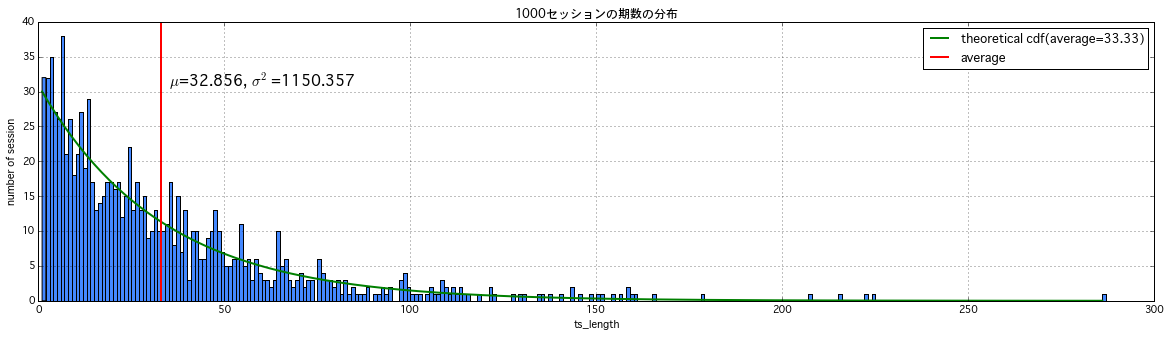

In [35]:
print("基本統計量:")
print(pd.DataFrame(ts_length, columns=["ts_length"]).describe())

print("\n33.33期未満: {0}%".format(ts_length[ts_length <= 33].size / 10))

fig, ax = plt.subplots(figsize=(20, 5))
plt.title("1000セッションの期数の分布")
# actual histogram
plt.hist(ts_length, bins=np.max(ts_length)-1, color='#4488FF')
# theoretical cdf
x = np.arange(1, np.max(ts_length))
plt.plot(x, stats.geom.pmf(x, 1-discount_v)*1000, linewidth=2, color='green', label="theoretical cdf(average=33.33)")
mu = np.mean(ts_length)
sigma = np.var(ts_length)
plt.xlabel("ts_length")
plt.ylabel("number of session")
ax.text(35, 30, r'''$\mu$={0:.3f}, $\sigma^2$={1:.3f}'''.format(mu, sigma), ha = 'left', va = 'bottom', size=15)
ax.grid(True)
ax.axvline(x=mu, linewidth=2, color='red', label="average")
plt.legend()
plt.show()

### 期数の長いセッション・短いセッションを5%ずつトリムすると

基本統計量:
       trimmed_ts_length
count            900.000
mean              28.756
std               22.608
min                2.000
25%               10.000
50%               23.000
75%               42.000
max              100.000

33.33期未満: 58.6%


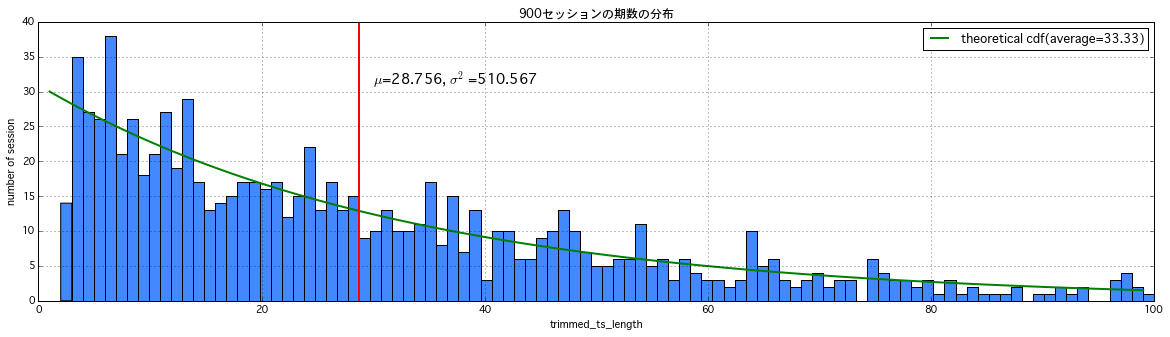

In [36]:
trimmed_ts_length = np.sort(ts_length)[50:950]
print("基本統計量:")
print(pd.DataFrame(trimmed_ts_length, columns=["trimmed_ts_length"]).describe())

print("\n33.33期未満: {0}%".format(trimmed_ts_length[trimmed_ts_length <= 33].size / 10))

mu = np.mean(trimmed_ts_length)
sigma = np.var(trimmed_ts_length)

fig, ax = plt.subplots(figsize=(20, 5))
plt.title("900セッションの期数の分布")

# actual histogram
plt.hist(trimmed_ts_length, bins=np.max(trimmed_ts_length)-1, color='#4488FF')

# theoretical cdf
x = np.arange(1, np.max(trimmed_ts_length))
plt.plot(x, stats.geom.pmf(x, 1-discount_v)*1000, linewidth=2, color='green', label="theoretical cdf(average=33.33)")

plt.xlabel("trimmed_ts_length")
plt.ylabel("number of session")
ax.text(30, 30, r'''$\mu$={0:.3f}, $\sigma^2$={1:.3f}'''.format(mu, sigma), ha = 'left', va = 'bottom', size=14)
ax.grid(True)
ax.axvline(x=mu, linewidth=2, color='red')
plt.legend()
plt.show()

2〜100期の範囲になる。

# Case1: perfect monitoring

結果の生データ(csv)は [contest1/data](./contest1/data)  
戦略は[user_strategies](./user_strategies)  
戦略のオートマトンは[contest1/automaton1.pdf](./contest1/automaton1.pdf)

In [7]:
strategies = [Iida_pm, PubStrategy, KatoStrategy, Self_Centered_perfect,
                       GrimTrigger, MyStrategy, beeleb, OyamaPerfectMonitoring, ogawa, yamagishi]
game = pl.RepeatedMatrixGame(payoff, strategies, signal=None, ts_length=ts_length, repeat=1000)
game.play(mtype="perfect", random_seed=seed, record=False)

Start
The object has 10 strategy functions below
--------------------------------------------------
1. Iida_perfect_monitoring.Iida_pm
2. mhanami_Public_Strategy.PubStrategy
3. kato.KatoStrategy
4. ikegami_perfect.Self_Centered_perfect
5. tsuyoshi.GrimTrigger
6. gistfile1.MyStrategy
7. beeleb_Strategy.beeleb
8. oyama.OyamaPerfectMonitoring
9. ogawa.ogawa
10. yamagishi_impd.yamagishi
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "Iida_perfect_monitoring.Iida_pm" vs "mhanami_Public_Strategy.PubStrategy"
Game 2: "Iida_perfect_monitoring.Iida_pm" vs "kato.KatoStrategy"
Game 3: "Iida_perfect_monitoring.Iida_pm" vs "ikegami_perfect.Self_Centered_perfect"
Game 4: "Iida_perfect_monitoring.Iida_pm" vs "tsuyoshi.GrimTrigger"
Game 5: "Iida_perfect_monitoring.Iida_pm" vs "gistfile1.MyStrategy"
Game 6: "Iida_perfect_monitoring.Iida_pm" vs "beeleb_Strategy.beeleb"
Game 7: "Iida_perfect_monitoring.Iida_pm" vs "oyama.OyamaPerfectMonitoring"
Ga

## Summary


<table>
	<tbody>
		<tr>
			<th>
				Datetime
			</th>
			<td colspan="6">
				2015-12-04-18-23-58
			</td>
		</tr>
		<tr>
			<th>
				Monitoring type
			</th>
			<td colspan="6">
				perfect
			</td>
		</tr>
		<tr>
			<th>
				RandomSeed
			</th>
			<td colspan="6">
				282
			</td>
		</tr>
		<tr>
			<th>
				Repeats
			</th>
			<td colspan="6">
				1000
			</td>
		</tr>
		<tr>
			<th>
				Average ts_length
			</th>
			<td colspan="6">
				32.856
			</td>
		</tr>
		<tr>
			<th>
				Number of strategies
			</th>
			<td colspan="6">
				10
			</td>
		</tr>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Strategy name
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(stage based)
			</th>
			<th>
				備考
			</th>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				yamagishi_impd.yamagishi
			</td>
			<td>
				3.785542333
			</td>
			<td>
				1
			</td>
			<td>
				3.69566526
			</td>
			<td>
				1
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				ikegami_perfect.Self_Centered_perfect
			</td>
			<td>
				3.709163441
			</td>
			<td>
				2
			</td>
			<td>
				3.569823202
			</td>
			<td>
				2
			</td>
			<td>
				30%
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				beeleb_Strategy.beeleb
			</td>
			<td>
				3.707132242
			</td>
			<td>
				3
			</td>
			<td>
				3.56862944
			</td>
			<td>
				3
			</td>
         <td></td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				mhanami_Public_Strategy.PubStrategy
			</td>
			<td>
				3.695745756
			</td>
			<td>
				4
			</td>
			<td>
				3.560563942
			</td>
			<td>
				4
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				oyama.OyamaPerfectMonitoring
			</td>
			<td>
				3.695585282
			</td>
			<td>
				5
			</td>
			<td>
				3.560097259
			</td>
			<td>
				5
			</td>
			<td>
				GT
			</td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				gistfile1.MyStrategy
			</td>
			<td>
				3.689240046
			</td>
			<td>
				6
			</td>
			<td>
				3.521959459
			</td>
			<td>
				6
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				Iida_perfect_monitoring.Iida_pm
			</td>
			<td>
				3.638486141
			</td>
			<td>
				7
			</td>
			<td>
				3.386765144
			</td>
			<td>
				8
			</td>
         <td></td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				tsuyoshi.GrimTrigger
			</td>
			<td>
				3.617644214
			</td>
			<td>
				8
			</td>
			<td>
				3.408783784
			</td>
			<td>
				7
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				ogawa.ogawa
			</td>
			<td>
				3.479693556
			</td>
			<td>
				9
			</td>
			<td>
				3.13531775
			</td>
			<td>
				9
			</td>
         <td></td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				kato.KatoStrategy
			</td>
			<td>
				3.046090794
			</td>
			<td>
				10
			</td>
			<td>
				2.713737386
			</td>
			<td>
				10
			</td>
         <td></td>
		</tr>
	</tbody>
</table>

TFT = Tit for Tat, GT = GrimTrigger, 30% = {過去全てのシグナルが30%以上BならD、そうでなければCを返す}  
TFT' = Tit for Tatの亜種（確率を分岐条件に加える, stateを増やすなど）

全体的に平均利得が4に近い（= 協調がかなりの程度達成されている）。  
TFTが圧倒的に高い利得を得た一方で、定期的に必ずDを出す戦略（戦略9, 3）は平均利得が低くなっている。  

## 戦略別セッション平均の分布

箱ひげ図。赤い線: 中央値, 青い長方形: 25%〜75%

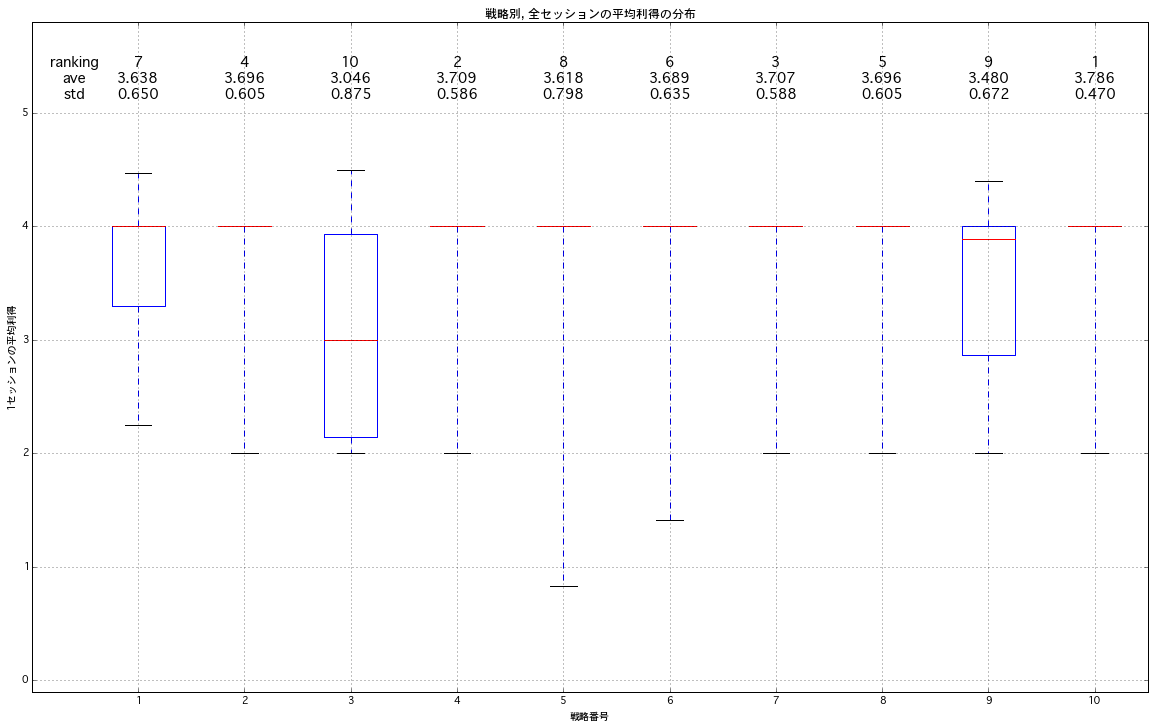

In [17]:
rounds = 1000 * 2
strategies = 10
max_ts = 100

# 読み込み
df = pd.read_csv('./contest1/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# 行: プレイヤー, 列: 1000*2セッション分の平均利得
average_matrix = np.zeros((rounds*(strategies-1), strategies), dtype=float)

for s in range(1, strategies+1):
    for i, opponent in enumerate(df[str(s)].columns.values):
        average_matrix[i*rounds:(i+1)*rounds, s-1] = df[str(s)][str(opponent)]

averages = np.zeros(strategies, dtype=float)
stds = np.zeros(strategies, dtype=float)
ranking = np.zeros(strategies, dtype=int)
for i in range(strategies):
    averages[i] = average_matrix[:, i].mean()
    stds[i] = average_matrix[:, i].std()
ranking = np.argsort(averages)[::-1]+1

fig, ax = plt.subplots(figsize=(20, 12))
bp = ax.boxplot(average_matrix, 0, '')
plt.grid()
plt.xlabel('戦略番号')
plt.ylabel('1セッションの平均利得')
ax.set_xlim([0, strategies+0.5])
ax.set_ylim([-0.1, 5.8])
plt.title('戦略別, 全セッションの平均利得の分布')
ax.text(0.4, 5.3, "ranking\nave\nstd", ha = 'center', va = 'center', color="black", size=14)
for i in range(strategies):
    ax.text(i+1, 5.3, "{0:.0f}\n{1:.3f}\n{2:.3f}"
            .format(np.where(ranking == i+1)[0][0]+1, averages[i], stds[i]), ha = 'center', va = 'center', color="black", size=14)

plt.show()

###基本統計量

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				1
			</th>
			<th>
				2
			</th>
			<th>
				3
			</th>
			<th>
				4
			</th>
			<th>
				5
			</th>
			<th>
				6
			</th>
			<th>
				7
			</th>
			<th>
				8
			</th>
			<th>
				9
			</th>
			<th>
				10
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				rank
			</th>
			<td>
				7
			</td>
			<td>
				4
			</td>
			<td>
				10
			</td>
			<td>
				2
			</td>
			<td>
				8
			</td>
			<td>
				6
			</td>
			<td>
				3
			</td>
			<td>
				5
			</td>
			<td>
				9
			</td>
			<td>
				1
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.638486
			</td>
			<td>
				3.695746
			</td>
			<td>
				3.046091
			</td>
			<td>
				3.709163
			</td>
			<td>
				3.617644
			</td>
			<td>
				3.68924
			</td>
			<td>
				3.707132
			</td>
			<td>
				3.695585
			</td>
			<td>
				3.479694
			</td>
			<td>
				3.785542
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.649774
			</td>
			<td>
				0.604642
			</td>
			<td>
				0.874775
			</td>
			<td>
				0.58606
			</td>
			<td>
				0.7979
			</td>
			<td>
				0.634951
			</td>
			<td>
				0.588227
			</td>
			<td>
				0.604742
			</td>
			<td>
				0.672512
			</td>
			<td>
				0.469952
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				1.801394
			</td>
			<td>
				2
			</td>
			<td>
				2.003484
			</td>
			<td>
				2
			</td>
			<td>
				0.828571
			</td>
			<td>
				1.41791
			</td>
			<td>
				2
			</td>
			<td>
				2
			</td>
			<td>
				2
			</td>
			<td>
				2
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				3.3
			</td>
			<td>
				4
			</td>
			<td>
				2.142857
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				2.866667
			</td>
			<td>
				4
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.892857
			</td>
			<td>
				4
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.931034
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.466899
			</td>
			<td>
				4
			</td>
			<td>
				4.5
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4.4
			</td>
			<td>
				4
			</td>
		</tr>
	</tbody>
</table>

1位のTFTが最も標準偏差が小さい。全体的に、分散が小さいほど高い順位となった。

## 期数による平均利得の変化

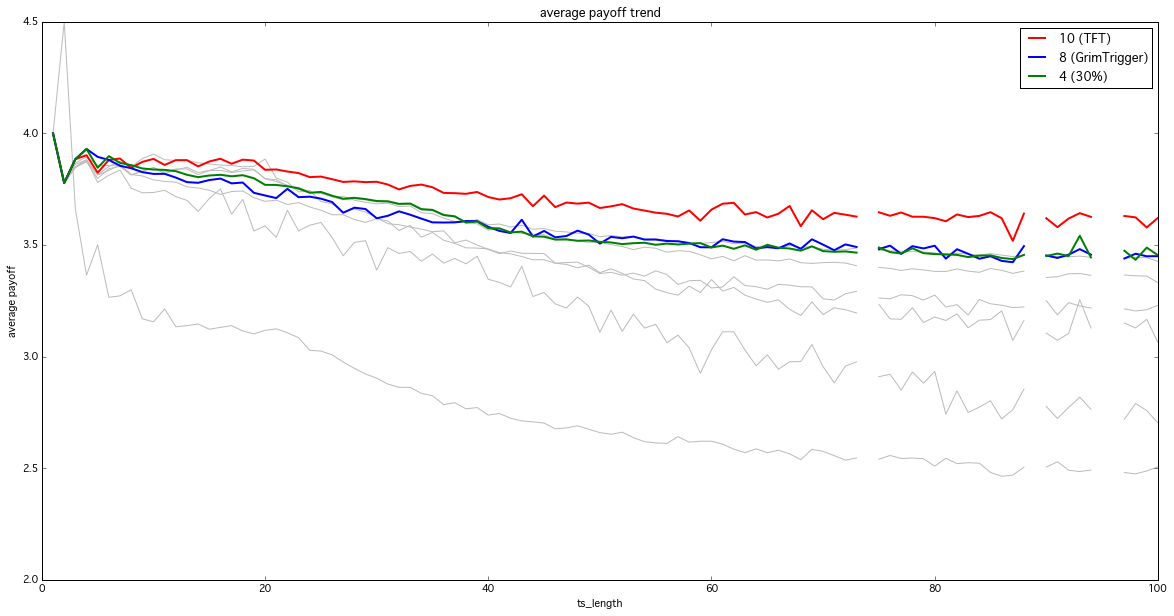

In [26]:
rounds = 1000 * 2
strategies = 10
max_ts = 100

# 読み込み
df = pd.read_csv('./contest1/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜100期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)

for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]
    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("average payoff trend")
plt.xlabel("ts_length")
plt.ylabel("average payoff")
t_list = [i for i in range(1, max_ts+1)]

for s in range(1, strategies+1):
    if s in [10, 8, 4]:
        pass
    else:
        average_list = average_matrix[s-1]
        plt.plot(t_list, average_list, color='#bbbbbb')

plt.plot(t_list, average_matrix[10-1], color='red', linewidth=2, label="10 (TFT)")
plt.plot(t_list, average_matrix[8-1], color='blue', linewidth=2, label="8 (GrimTrigger)")
plt.plot(t_list, average_matrix[4-1], color='green', linewidth=2, label="4 (30%)")
plt.legend()
plt.show()

TFTは期数の長いセッションで、他の戦略に比べて協調に成功している。

# Case2: imperfect public monitoring

結果の生データ(csv)は [contest2/data](./contest2/data)  
戦略は[user_strategies](./user_strategies)  
戦略のオートマトンは[contest2/automaton2.pdf](./contest2/automaton2.pdf)

In [8]:
# プロジェクトが成功か失敗かを返す
def public_signal(actions, random_state):
    prob = random_state.uniform()
    if actions[0] == 0 and actions[1] == 0:
        return 0 if prob < 0.9 else 1
    elif (actions[0] == 0 and actions[1] == 1) or (actions[0] == 1 and actions[1] == 0):
        return 0 if prob < 0.5 else 1
    elif actions[0] == 1 and actions[1] == 1:
        return 0 if prob < 0.2 else 1
    else:
        raise ValueError

strategies = [Iida_ipm, ImPubStrategy, KatoStrategy, Self_Centered_public, GrimTrigger,
              MyStrategy, beeleb, OyamaImperfectPublicMonitoring, ogawa, yamagishi]
game = pl.RepeatedMatrixGame(payoff, strategies, signal=public_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="public", random_seed=seed, record=False)

Start
The object has 10 strategy functions below
--------------------------------------------------
1. Iida_imperfect_public.Iida_ipm
2. mhanami_Imperfect_Public_Strategy.ImPubStrategy
3. kato.KatoStrategy
4. ikegami_imperfect_public.Self_Centered_public
5. tsuyoshi.GrimTrigger
6. gistfile1.MyStrategy
7. beeleb_Strategy.beeleb
8. oyama.OyamaImperfectPublicMonitoring
9. ogawa.ogawa
10. yamagishi_impd.yamagishi
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "Iida_imperfect_public.Iida_ipm" vs "mhanami_Imperfect_Public_Strategy.ImPubStrategy"
Game 2: "Iida_imperfect_public.Iida_ipm" vs "kato.KatoStrategy"
Game 3: "Iida_imperfect_public.Iida_ipm" vs "ikegami_imperfect_public.Self_Centered_public"
Game 4: "Iida_imperfect_public.Iida_ipm" vs "tsuyoshi.GrimTrigger"
Game 5: "Iida_imperfect_public.Iida_ipm" vs "gistfile1.MyStrategy"
Game 6: "Iida_imperfect_public.Iida_ipm" vs "beeleb_Strategy.beeleb"
Game 7: "Iida_imperfect_public.Iida_i

## Summary

<table>
	<tbody>
		<tr>
			<th>
				Datetime
			</th>
			<td colspan="6">
				2015-12-04-19-27-41
			</td>
		</tr>
		<tr>
			<th>
				Monitoring type
			</th>
			<td colspan="6">
				public
			</td>
		</tr>
		<tr>
			<th>
				RandomSeed
			</th>
			<td colspan="6">
				282
			</td>
		</tr>
		<tr>
			<th>
				Repeats
			</th>
			<td colspan="6">
				1000
			</td>
		</tr>
		<tr>
			<th>
				Average ts_length
			</th>
			<td colspan="6">
				32.856
			</td>
		</tr>
		<tr>
			<th>
				Number of strategies
			</th>
			<td colspan="6">
				10
			</td>
		</tr>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Strategy name
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(stage based)
			</th>
			<th>
				備考
			</th>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				mhanami_Imperfect_Public_Strategy.ImPubStrategy
			</td>
			<td>
				3.426505902
			</td>
			<td>
				1
			</td>
			<td>
				3.085798636
			</td>
			<td>
				1
			</td>
			<td>
				ALLD
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				kato.KatoStrategy
			</td>
			<td>
				3.300688557
			</td>
			<td>
				2
			</td>
			<td>
				3.082721235
			</td>
			<td>
				2
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				ikegami_imperfect_public.Self_Centered_public
			</td>
			<td>
				3.204767877
			</td>
			<td>
				3
			</td>
			<td>
				3.024595541
			</td>
			<td>
				4
			</td>
			<td>
				25%
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				oyama.OyamaImperfectPublicMonitoring
			</td>
			<td>
				3.164308602
			</td>
			<td>
				4
			</td>
			<td>
				3.06851446
			</td>
			<td>
				3
			</td>
			<td>
				GT'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				Iida_imperfect_public.Iida_ipm
			</td>
			<td>
				3.15370844
			</td>
			<td>
				5
			</td>
			<td>
				2.949672646
			</td>
			<td>
				5
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				yamagishi_impd.yamagishi
			</td>
			<td>
				3.060373179
			</td>
			<td>
				6
			</td>
			<td>
				2.824435922
			</td>
			<td>
				7
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				ogawa.ogawa
			</td>
			<td>
				3.02123959
			</td>
			<td>
				7
			</td>
			<td>
				2.910746896
			</td>
			<td>
				6
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				tsuyoshi.GrimTrigger
			</td>
			<td>
				2.873939966
			</td>
			<td>
				8
			</td>
			<td>
				2.566333225
			</td>
			<td>
				8
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				beeleb_Strategy.beeleb
			</td>
			<td>
				2.80155086
			</td>
			<td>
				9
			</td>
			<td>
				2.545187079
			</td>
			<td>
				9
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				gistfile1.MyStrategy
			</td>
			<td>
				2.781473904
			</td>
			<td>
				10
			</td>
			<td>
				2.45014271
			</td>
			<td>
				10
			</td>
			<td>
				TFT'
			</td>
		</tr>
	</tbody>
</table>

戦略2（ALLD）と戦略3（定期的にDを出す戦略）が上位となった。

## 戦略別セッション平均の分布

箱ひげ図。赤い線: 中央値, 青い長方形: 25%〜75%

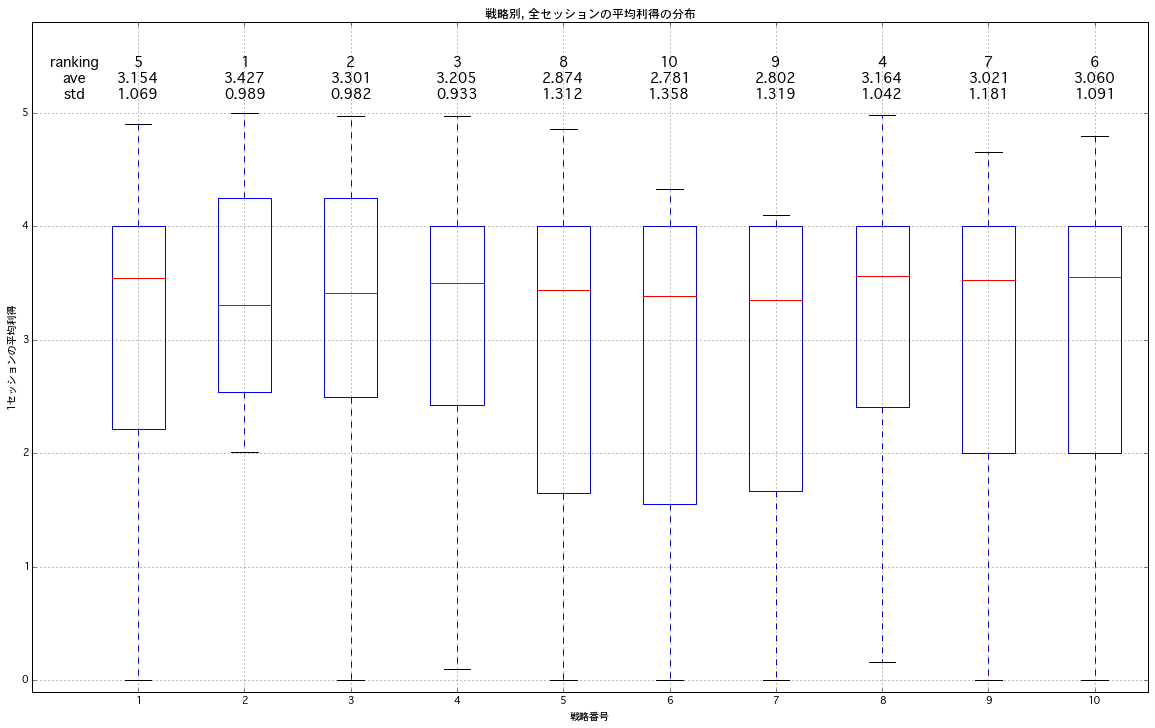

In [18]:
rounds = 1000 * 2
strategies = 10
max_ts = 100

# 読み込み
df = pd.read_csv('./contest2/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# 行: プレイヤー, 列: 1000*2セッション分の平均利得
average_matrix = np.zeros((rounds*(strategies-1), strategies), dtype=float)

for s in range(1, strategies+1):
    for i, opponent in enumerate(df[str(s)].columns.values):
        average_matrix[i*rounds:(i+1)*rounds, s-1] = df[str(s)][str(opponent)]

averages = np.zeros(strategies, dtype=float)
stds = np.zeros(strategies, dtype=float)
ranking = np.zeros(strategies, dtype=int)
for i in range(strategies):
    averages[i] = average_matrix[:, i].mean()
    stds[i] = average_matrix[:, i].std()
ranking = np.argsort(averages)[::-1]+1

fig, ax = plt.subplots(figsize=(20, 12))
bp = ax.boxplot(average_matrix, 0, '')
plt.grid()
plt.xlabel('戦略番号')
plt.ylabel('1セッションの平均利得')
ax.set_xlim([0, strategies+0.5])
ax.set_ylim([-0.1, 5.8])
plt.title('戦略別, 全セッションの平均利得の分布')
ax.text(0.4, 5.3, "ranking\nave\nstd", ha = 'center', va = 'center', color="black", size=14)
for i in range(strategies):
    ax.text(i+1, 5.3, "{0:.0f}\n{1:.3f}\n{2:.3f}"
            .format(np.where(ranking == i+1)[0][0]+1, averages[i], stds[i]), ha = 'center', va = 'center', color="black", size=14)

plt.show()

### 基本統計量

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				1
			</th>
			<th>
				2
			</th>
			<th>
				3
			</th>
			<th>
				4
			</th>
			<th>
				5
			</th>
			<th>
				6
			</th>
			<th>
				7
			</th>
			<th>
				8
			</th>
			<th>
				9
			</th>
			<th>
				10
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				rank
			</th>
			<td>
				5
			</td>
			<td>
				1
			</td>
			<td>
				2
			</td>
			<td>
				3
			</td>
			<td>
				8
			</td>
			<td>
				10
			</td>
			<td>
				9
			</td>
			<td>
				4
			</td>
			<td>
				7
			</td>
			<td>
				6
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.153708
			</td>
			<td>
				3.426506
			</td>
			<td>
				3.300689
			</td>
			<td>
				3.204768
			</td>
			<td>
				2.87394
			</td>
			<td>
				2.781474
			</td>
			<td>
				2.801551
			</td>
			<td>
				3.164309
			</td>
			<td>
				3.02124
			</td>
			<td>
				3.060373
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				1.068773
			</td>
			<td>
				0.989293
			</td>
			<td>
				0.981721
			</td>
			<td>
				0.932929
			</td>
			<td>
				1.311979
			</td>
			<td>
				1.35814
			</td>
			<td>
				1.319016
			</td>
			<td>
				1.042236
			</td>
			<td>
				1.180943
			</td>
			<td>
				1.091448
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				0
			</td>
			<td>
				2.010453
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.215385
			</td>
			<td>
				2.545455
			</td>
			<td>
				2.496503
			</td>
			<td>
				2.425827
			</td>
			<td>
				1.653061
			</td>
			<td>
				1.555556
			</td>
			<td>
				1.672578
			</td>
			<td>
				2.406039
			</td>
			<td>
				2
			</td>
			<td>
				2
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.545455
			</td>
			<td>
				3.3125
			</td>
			<td>
				3.416667
			</td>
			<td>
				3.5
			</td>
			<td>
				3.44
			</td>
			<td>
				3.384615
			</td>
			<td>
				3.353095
			</td>
			<td>
				3.563063
			</td>
			<td>
				3.532292
			</td>
			<td>
				3.558846
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				4
			</td>
			<td>
				4.25
			</td>
			<td>
				4.25
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.9
			</td>
			<td>
				5
			</td>
			<td>
				4.97619
			</td>
			<td>
				4.97561
			</td>
			<td>
				4.857143
			</td>
			<td>
				4.333333
			</td>
			<td>
				4.103448
			</td>
			<td>
				4.981481
			</td>
			<td>
				4.659574
			</td>
			<td>
				4.8
			</td>
		</tr>
	</tbody>
</table>

実験1とは異なり, 分散と順位の間に明確な関係は見られない。

## 期数による平均利得の変化

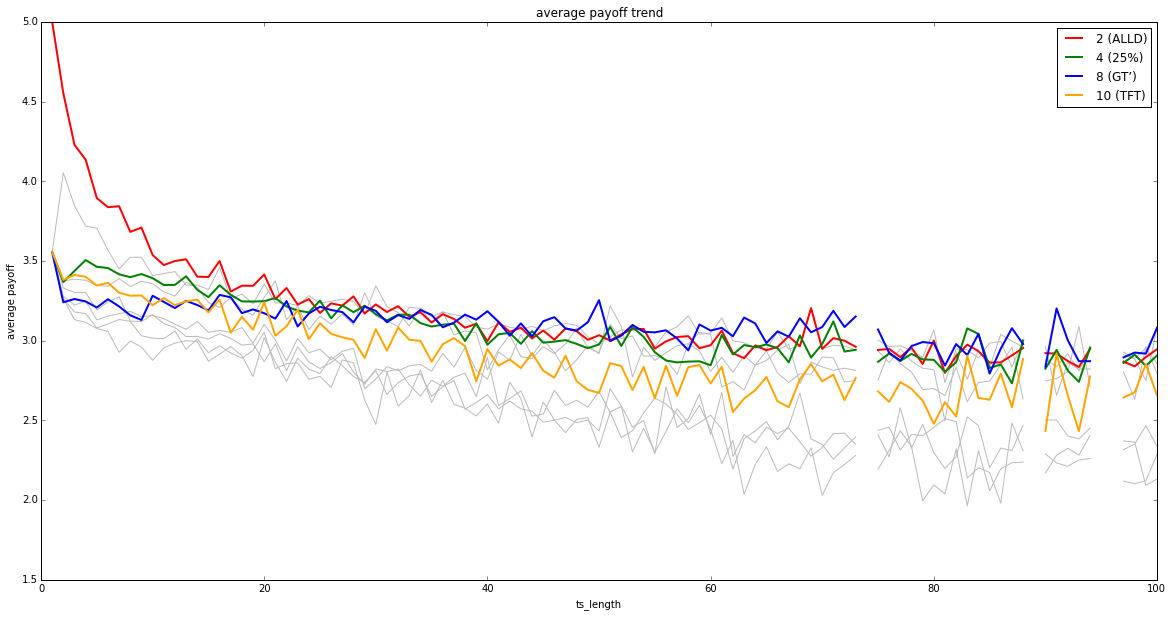

In [34]:
rounds = 1000 * 2
strategies = 10
max_ts = 100

# 読み込み
df = pd.read_csv('./contest2/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜100期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)

for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]
    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("average payoff trend")
plt.xlabel("ts_length")
plt.ylabel("average payoff")
t_list = [i for i in range(1, max_ts+1)]

for s in range(1, strategies+1):
    if s in [2, 8, 4, 10]:
        pass
    else:
        average_list = average_matrix[s-1]
        plt.plot(t_list, average_list, color='#bbbbbb')

plt.plot(t_list, average_matrix[2-1], color='red', linewidth=2, label="2 (ALLD)")
plt.plot(t_list, average_matrix[4-1], color='green', linewidth=2, label="4 (25%)")
plt.plot(t_list, average_matrix[8-1], color='blue', linewidth=2, label="8 (GT’)")
plt.plot(t_list, average_matrix[10-1], color='orange', linewidth=2, label="10 (TFT)")
plt.legend()
plt.show()

上位の戦略は、期数の短長にかかわらず、安定した平均利得をえている。  
ALLDは特に短い期数のセッションでの平均利得が大きく、1位になった要因だと考えられる。

# Case3: imperfect private monitoring（尾山ゼミの戦略のみ）

結果の生データ(csv)は [contest3/data](./contest3/data)  
戦略は[user_strategies](./user_strategies)  
戦略のオートマトンは[contest3/automaton3.pdf](./contest3/automaton3.pdf)

In [13]:
# 「相手の」シグナルが協調か攻撃かを（ノイズ付きで）返す
def private_signal(actions, random_state):
    pattern = [[0, 0], [0, 1], [1, 0], [1, 1]]
    # 例えば実際の行動が(0, 1)なら、シグナルは(1, 0)である可能性が最も高い
    signal_probs = [[.9, .02, .02, .06], [.02, .06, .9, .02], [.02, .9, .06, .02], [.06, .02, .02, .9]]
    p = random_state.uniform()
    if actions[0] == 0 and actions[1] == 0:
        return [0, 0] if p < 0.9 else [0, 1] if p < 0.92 else [1, 0] if p < 0.94 else [1, 1]
    elif actions[0] == 0 and actions[1] == 1:
        return [1, 0] if p < 0.9 else [0, 0] if p < 0.92 else [1, 1] if p < 0.94 else [0, 1]
    elif actions[0] == 1 and actions[1] == 0:
        return [0, 1] if p < 0.9 else [1, 1] if p < 0.92 else [0, 0] if p < 0.94 else [1, 0]
    elif actions[0] == 1 and actions[1] == 1:
        return [1, 1] if p < 0.9 else [1, 0] if p < 0.92 else [0, 1] if p < 0.94 else [0, 0]
    else:
        raise ValueError

strategies = [Iida_iprm, ImPrivStrategy, KatoStrategy, Self_Centered_private, GrimTrigger,
              MyStrategy, beeleb, OyamaImperfectPrivateMonitoring, ogawa, yamagishi]
game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)

Start
The object has 10 strategy functions below
--------------------------------------------------
1. Iida_imperfect_private.Iida_iprm
2. mhanami_Imperfect_Private_Strategy.ImPrivStrategy
3. kato.KatoStrategy
4. ikegami_imperfect_private.Self_Centered_private
5. tsuyoshi.GrimTrigger
6. gistfile1.MyStrategy
7. beeleb_Strategy.beeleb
8. oyama.OyamaImperfectPrivateMonitoring
9. ogawa.ogawa
10. yamagishi_impd.yamagishi
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "Iida_imperfect_private.Iida_iprm" vs "mhanami_Imperfect_Private_Strategy.ImPrivStrategy"
Game 2: "Iida_imperfect_private.Iida_iprm" vs "kato.KatoStrategy"
Game 3: "Iida_imperfect_private.Iida_iprm" vs "ikegami_imperfect_private.Self_Centered_private"
Game 4: "Iida_imperfect_private.Iida_iprm" vs "tsuyoshi.GrimTrigger"
Game 5: "Iida_imperfect_private.Iida_iprm" vs "gistfile1.MyStrategy"
Game 6: "Iida_imperfect_private.Iida_iprm" vs "beeleb_Strategy.beeleb"
Game 7: "Iida_

## Summary

<table>
	<tbody>
		<tr>
			<th>
				Datetime
			</th>
			<td colspan="6">
				2015-12-05-00-14-04
			</td>
		</tr>
		<tr>
			<th>
				Monitoring type
			</th>
			<td colspan="6">
				private
			</td>
		</tr>
		<tr>
			<th>
				RandomSeed
			</th>
			<td colspan="6">
				282
			</td>
		</tr>
		<tr>
			<th>
				Repeats
			</th>
			<td colspan="6">
				1000
			</td>
		</tr>
		<tr>
			<th>
				Average ts_length
			</th>
			<td colspan="6">
				32.856
			</td>
		</tr>
		<tr>
			<th>
				Number of strategies
			</th>
			<td colspan="6">
				10
			</td>
		</tr>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Strategy name
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(stage based)
			</th>
			<th>
				備考
			</th>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				beeleb_Strategy.beeleb
			</td>
			<td>
				3.458461687
			</td>
			<td>
				1
			</td>
			<td>
				3.293973027
			</td>
			<td>
				1
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				yamagishi_impd.yamagishi
			</td>
			<td>
				3.445953725
			</td>
			<td>
				2
			</td>
			<td>
				3.239141168
			</td>
			<td>
				3
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				mhanami_Imperfect_Private_Strategy.ImPrivStrategy
			</td>
			<td>
				3.445605137
			</td>
			<td>
				3
			</td>
			<td>
				3.256924154
			</td>
			<td>
				2
			</td>
			<td>
				2T2FT
			</td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				gistfile1.MyStrategy
			</td>
			<td>
				3.426852855
			</td>
			<td>
				4
			</td>
			<td>
				3.213336647
			</td>
			<td>
				4
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				oyama.OyamaImperfectPrivateMonitoring
			</td>
			<td>
				3.405064024
			</td>
			<td>
				5
			</td>
			<td>
				3.178198469
			</td>
			<td>
				5
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				Iida_imperfect_private.Iida_iprm
			</td>
			<td>
				3.389575102
			</td>
			<td>
				6
			</td>
			<td>
				3.114596015
			</td>
			<td>
				7
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				ogawa.ogawa
			</td>
			<td>
				3.389554064
			</td>
			<td>
				7
			</td>
			<td>
				3.095465398
			</td>
			<td>
				8
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				ikegami_imperfect_private.Self_Centered_private
			</td>
			<td>
				3.374520784
			</td>
			<td>
				8
			</td>
			<td>
				3.137879433
			</td>
			<td>
				6
			</td>
			<td>
				20%
			</td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				tsuyoshi.GrimTrigger
			</td>
			<td>
				3.244853934
			</td>
			<td>
				9
			</td>
			<td>
				2.928183251
			</td>
			<td>
				9
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				kato.KatoStrategy
			</td>
			<td>
				3.240895862
			</td>
			<td>
				10
			</td>
			<td>
				2.899218475
			</td>
			<td>
				10
			</td>
			<td></td>
		</tr>
	</tbody>
</table>

## 戦略別, セッション平均利得の分布

箱ひげ図。赤い線: 中央値, 青い長方形: 25%〜75%

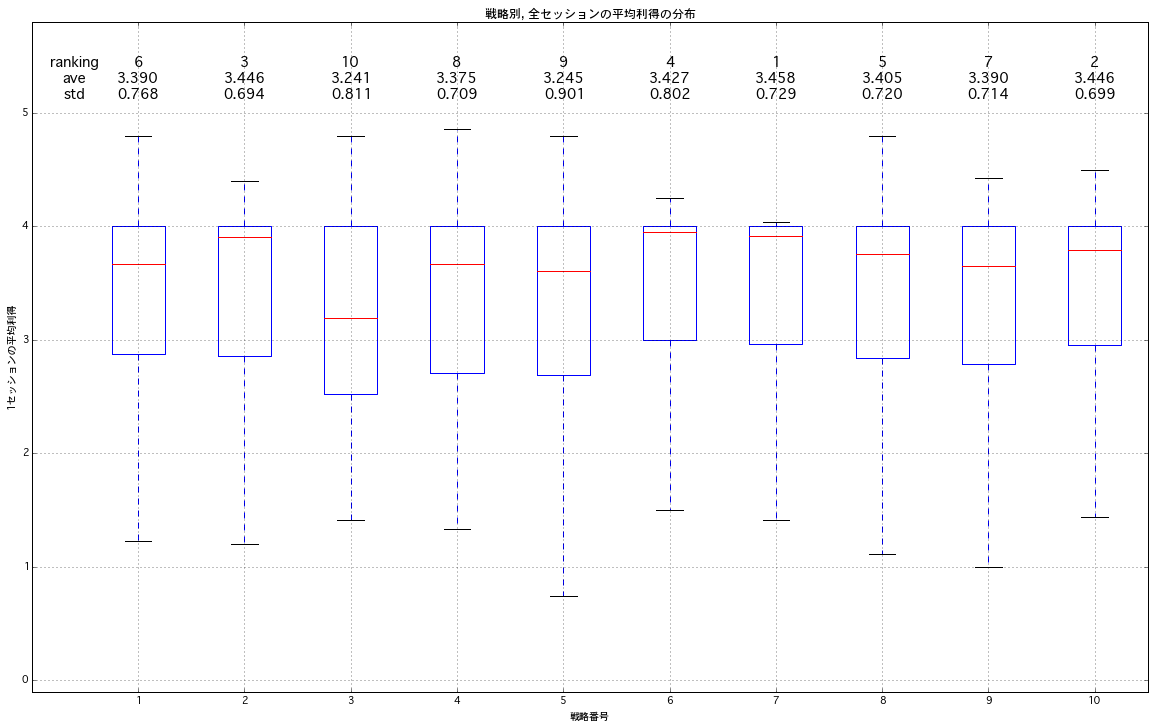

In [19]:
rounds = 1000 * 2
strategies = 10
max_ts = 100

# 読み込み
df = pd.read_csv('./contest3/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# 行: プレイヤー, 列: 1000*2セッション分の平均利得
average_matrix = np.zeros((rounds*(strategies-1), strategies), dtype=float)

for s in range(1, strategies+1):
    for i, opponent in enumerate(df[str(s)].columns.values):
        average_matrix[i*rounds:(i+1)*rounds, s-1] = df[str(s)][str(opponent)]

averages = np.zeros(strategies, dtype=float)
stds = np.zeros(strategies, dtype=float)
ranking = np.zeros(strategies, dtype=int)
for i in range(strategies):
    averages[i] = average_matrix[:, i].mean()
    stds[i] = average_matrix[:, i].std()
ranking = np.argsort(averages)[::-1]+1

fig, ax = plt.subplots(figsize=(20, 12))
bp = ax.boxplot(average_matrix, 0, '')
plt.grid()
plt.xlabel('戦略番号')
plt.ylabel('1セッションの平均利得')
ax.set_xlim([0, strategies+0.5])
ax.set_ylim([-0.1, 5.8])
plt.title('戦略別, 全セッションの平均利得の分布')
ax.text(0.4, 5.3, "ranking\nave\nstd", ha = 'center', va = 'center', color="black", size=14)
for i in range(strategies):
    ax.text(i+1, 5.3, "{0:.0f}\n{1:.3f}\n{2:.3f}"
            .format(np.where(ranking == i+1)[0][0]+1, averages[i], stds[i]), ha = 'center', va = 'center', color="black", size=14)

plt.show()

### 基本統計量

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				1
			</th>
			<th>
				2
			</th>
			<th>
				3
			</th>
			<th>
				4
			</th>
			<th>
				5
			</th>
			<th>
				6
			</th>
			<th>
				7
			</th>
			<th>
				8
			</th>
			<th>
				9
			</th>
			<th>
				10
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				rank
			</th>
			<td>
				6
			</td>
			<td>
				3
			</td>
			<td>
				10
			</td>
			<td>
				8
			</td>
			<td>
				9
			</td>
			<td>
				4
			</td>
			<td>
				1
			</td>
			<td>
				5
			</td>
			<td>
				7
			</td>
			<td>
				2
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
			<td>
				18000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.389575
			</td>
			<td>
				3.445605
			</td>
			<td>
				3.240896
			</td>
			<td>
				3.374521
			</td>
			<td>
				3.244854
			</td>
			<td>
				3.426853
			</td>
			<td>
				3.458462
			</td>
			<td>
				3.405064
			</td>
			<td>
				3.389554
			</td>
			<td>
				3.445954
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.767754
			</td>
			<td>
				0.693915
			</td>
			<td>
				0.811377
			</td>
			<td>
				0.70892
			</td>
			<td>
				0.901283
			</td>
			<td>
				0.80159
			</td>
			<td>
				0.729059
			</td>
			<td>
				0.720129
			</td>
			<td>
				0.714496
			</td>
			<td>
				0.699362
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				1.230769
			</td>
			<td>
				1.2
			</td>
			<td>
				1.416667
			</td>
			<td>
				1.333333
			</td>
			<td>
				0.571429
			</td>
			<td>
				0.615385
			</td>
			<td>
				0.666667
			</td>
			<td>
				0.571429
			</td>
			<td>
				0.8
			</td>
			<td>
				1.333333
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.875
			</td>
			<td>
				2.857143
			</td>
			<td>
				2.526316
			</td>
			<td>
				2.707154
			</td>
			<td>
				2.695652
			</td>
			<td>
				3
			</td>
			<td>
				2.962963
			</td>
			<td>
				2.84
			</td>
			<td>
				2.792308
			</td>
			<td>
				2.952381
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.666667
			</td>
			<td>
				3.911111
			</td>
			<td>
				3.195387
			</td>
			<td>
				3.666667
			</td>
			<td>
				3.607143
			</td>
			<td>
				3.947114
			</td>
			<td>
				3.917526
			</td>
			<td>
				3.758621
			</td>
			<td>
				3.652618
			</td>
			<td>
				3.793103
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.8
			</td>
			<td>
				4.4
			</td>
			<td>
				4.8
			</td>
			<td>
				4.857143
			</td>
			<td>
				4.8
			</td>
			<td>
				4.25
			</td>
			<td>
				4.038462
			</td>
			<td>
				4.8
			</td>
			<td>
				4.428571
			</td>
			<td>
				4.5
			</td>
		</tr>
	</tbody>
</table>

## 期数による平均利得の変化

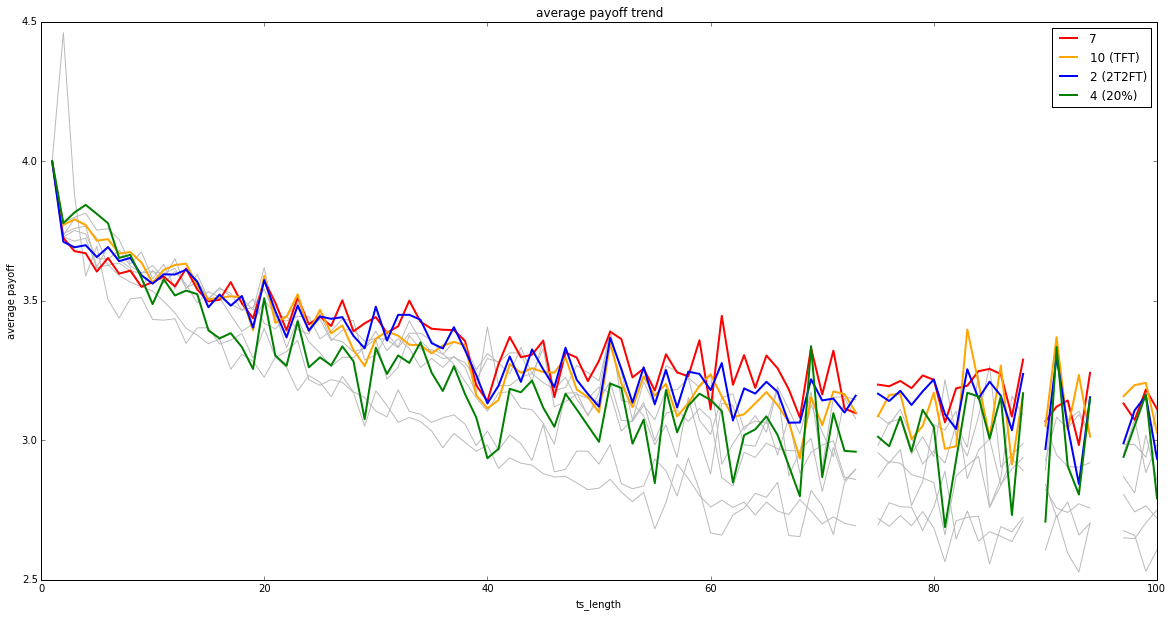

In [35]:
rounds = 1000 * 2
strategies = 10
max_ts = 100

# 読み込み
df = pd.read_csv('./contest3/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜100期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)

for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]
    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("average payoff trend")
plt.xlabel("ts_length")
plt.ylabel("average payoff")
t_list = [i for i in range(1, max_ts+1)]

for s in range(1, strategies+1):
    if s in [2, 7, 4, 10]:
        pass
    else:
        average_list = average_matrix[s-1]
        plt.plot(t_list, average_list, color='#bbbbbb')

plt.plot(t_list, average_matrix[7-1], color='red', linewidth=2, label="7")
plt.plot(t_list, average_matrix[10-1], color='orange', linewidth=2, label="10 (TFT)")
plt.plot(t_list, average_matrix[2-1], color='blue', linewidth=2, label="2 (2T2FT)")
plt.plot(t_list, average_matrix[4-1], color='green', linewidth=2, label="4 (20%)")
plt.legend()
plt.show()

期数が長くなるに従って、協調がしづらくなっていることがわかる。TFT同士の対戦では、このようなことが一般に起こる（後述）

# Case4: imperfect private monitoring（神取ゼミの戦略のみ）

結果の生データ(csv)は [contest4/data](./contest4/data)  
戦略は [user_strategies](./user_strategies)  
戦略のオートマトンは [contest4/automaton4.pdf](./contest4/automaton4.pdf)  
神取ゼミの元実験と尾山ゼミでの再実験の比較（各対戦毎のセッション平均利得の違い） [contest4/神取ゼミ実験_尾山ゼミ再実験比較.xlsx](./contest4/神取ゼミ実験_尾山ゼミ再実験比較.xlsx)

In [14]:
# 「相手の」シグナルが協調か攻撃かを（ノイズ付きで）返す
def private_signal(actions, random_state):
    pattern = [[0, 0], [0, 1], [1, 0], [1, 1]]
    # 例えば実際の行動が(0, 1)なら、シグナルは(1, 0)である可能性が最も高い
    signal_probs = [[.9, .02, .02, .06], [.02, .06, .9, .02], [.02, .9, .06, .02], [.06, .02, .02, .9]]
    p = random_state.uniform()
    if actions[0] == 0 and actions[1] == 0:
        return [0, 0] if p < 0.9 else [0, 1] if p < 0.92 else [1, 0] if p < 0.94 else [1, 1]
    elif actions[0] == 0 and actions[1] == 1:
        return [1, 0] if p < 0.9 else [0, 0] if p < 0.92 else [1, 1] if p < 0.94 else [0, 1]
    elif actions[0] == 1 and actions[1] == 0:
        return [0, 1] if p < 0.9 else [1, 1] if p < 0.92 else [0, 0] if p < 0.94 else [1, 0]
    elif actions[0] == 1 and actions[1] == 1:
        return [1, 1] if p < 0.9 else [1, 0] if p < 0.92 else [0, 1] if p < 0.94 else [0, 0]
    else:
        raise ValueError

strategies = [Strategy1, Strategy2, Strategy3, Strategy4, Strategy5,
                    Strategy6, Strategy7, Strategy8, Strategy9, Strategy10,
                    Strategy11, Strategy12, Strategy13, Strategy14, Strategy15,
                    Strategy16, Strategy17, Strategy18, Strategy19, Strategy20, 
                    Strategy21, Strategy22, Strategy23, Strategy24]
    
game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)


Start
The object has 24 strategy functions below
--------------------------------------------------
1. kandori.Strategy1
2. kandori.Strategy2
3. kandori.Strategy3
4. kandori.Strategy4
5. kandori.Strategy5
6. kandori.Strategy6
7. kandori.Strategy7
8. kandori.Strategy8
9. kandori.Strategy9
10. kandori.Strategy10
11. kandori.Strategy11
12. kandori.Strategy12
13. kandori.Strategy13
14. kandori.Strategy14
15. kandori.Strategy15
16. kandori.Strategy16
17. kandori.Strategy17
18. kandori.Strategy18
19. kandori.Strategy19
20. kandori.Strategy20
21. kandori.Strategy21
22. kandori.Strategy22
23. kandori.Strategy23
24. kandori.Strategy24
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "kandori.Strategy1" vs "kandori.Strategy2"
Game 2: "kandori.Strategy1" vs "kandori.Strategy3"
Game 3: "kandori.Strategy1" vs "kandori.Strategy4"
Game 4: "kandori.Strategy1" vs "kandori.Strategy5"
Game 5: "kandori.Strategy1" vs "kandori.Strategy6"
Game 6: "kando

## Summary

<table>
	<thead>
		<tr>
			<th>
				Datetime
			</th>
			<th colspan="6">
				2015-12-05-01-07-37
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				Monitoring type
			</th>
			<td colspan="6">
				private
			</td>
		</tr>
		<tr>
			<th>
				RandomSeed
			</th>
			<td colspan="6">
				282
			</td>
		</tr>
		<tr>
			<th>
				Repeats
			</th>
			<td colspan="6">
				1000
			</td>
		</tr>
		<tr>
			<th>
				Average ts_length
			</th>
			<td colspan="6">
				32.856
			</td>
		</tr>
		<tr>
			<th>
				Number of strategies
			</th>
			<td colspan="6">
				24
			</td>
		</tr>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Strategy name
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(trimmed)
			</th>
			<th>
				備考
			</th>
		</tr>
		<tr>
			<th>
				18
			</th>
			<td>
				kandori.Strategy18
			</td>
			<td>
				3.35352416
			</td>
			<td>
				1
			</td>
			<td>
				3.219810292
			</td>
			<td>
				1
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				13
			</th>
			<td>
				kandori.Strategy13
			</td>
			<td>
				3.326308014
			</td>
			<td>
				2
			</td>
			<td>
				3.182248494
			</td>
			<td>
				2
			</td>
			<td>
				CCDDDD
			</td>
		</tr>
		<tr>
			<th>
				22
			</th>
			<td>
				kandori.Strategy22
			</td>
			<td>
				3.259068663
			</td>
			<td>
				3
			</td>
			<td>
				3.121244482
			</td>
			<td>
				4
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				14
			</th>
			<td>
				kandori.Strategy14
			</td>
			<td>
				3.258886509
			</td>
			<td>
				4
			</td>
			<td>
				3.122727237
			</td>
			<td>
				3
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				kandori.Strategy1
			</td>
			<td>
				3.256299103
			</td>
			<td>
				5
			</td>
			<td>
				3.132024724
			</td>
			<td>
				5
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				kandori.Strategy3
			</td>
			<td>
				3.240387724
			</td>
			<td>
				6
			</td>
			<td>
				3.082433491
			</td>
			<td>
				6
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				21
			</th>
			<td>
				kandori.Strategy21
			</td>
			<td>
				3.238405281
			</td>
			<td>
				7
			</td>
			<td>
				3.083776638
			</td>
			<td>
				7
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				kandori.Strategy2
			</td>
			<td>
				3.215812884
			</td>
			<td>
				8
			</td>
			<td>
				3.054822228
			</td>
			<td>
				9
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				16
			</th>
			<td>
				kandori.Strategy16
			</td>
			<td>
				3.215812884
			</td>
			<td>
				9
			</td>
			<td>
				3.054822228
			</td>
			<td>
				10
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				17
			</th>
			<td>
				kandori.Strategy17
			</td>
			<td>
				3.215547504
			</td>
			<td>
				10
			</td>
			<td>
				3.063675088
			</td>
			<td>
				8
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				19
			</th>
			<td>
				kandori.Strategy19
			</td>
			<td>
				3.213334955
			</td>
			<td>
				11
			</td>
			<td>
				3.06115156
			</td>
			<td>
				11
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				kandori.Strategy6
			</td>
			<td>
				3.197763649
			</td>
			<td>
				12
			</td>
			<td>
				3.056192503
			</td>
			<td>
				12
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				12
			</th>
			<td>
				kandori.Strategy12
			</td>
			<td>
				3.197073568
			</td>
			<td>
				13
			</td>
			<td>
				3.045809911
			</td>
			<td>
				16
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				20
			</th>
			<td>
				kandori.Strategy20
			</td>
			<td>
				3.192768288
			</td>
			<td>
				14
			</td>
			<td>
				3.020367533
			</td>
			<td>
				13
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				kandori.Strategy4
			</td>
			<td>
				3.191465329
			</td>
			<td>
				15
			</td>
			<td>
				3.086214152
			</td>
			<td>
				14
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				23
			</th>
			<td>
				kandori.Strategy23
			</td>
			<td>
				3.188569289
			</td>
			<td>
				16
			</td>
			<td>
				3.06617612
			</td>
			<td>
				15
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				kandori.Strategy7
			</td>
			<td>
				3.166979223
			</td>
			<td>
				17
			</td>
			<td>
				3.001625671
			</td>
			<td>
				17
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				15
			</th>
			<td>
				kandori.Strategy15
			</td>
			<td>
				3.161225612
			</td>
			<td>
				18
			</td>
			<td>
				2.983885545
			</td>
			<td>
				19
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				11
			</th>
			<td>
				kandori.Strategy11
			</td>
			<td>
				3.159787981
			</td>
			<td>
				19
			</td>
			<td>
				3.004255063
			</td>
			<td>
				18
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				24
			</th>
			<td>
				kandori.Strategy24
			</td>
			<td>
				3.158548933
			</td>
			<td>
				20
			</td>
			<td>
				2.940998137
			</td>
			<td>
				21
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				kandori.Strategy10
			</td>
			<td>
				3.157508886
			</td>
			<td>
				21
			</td>
			<td>
				2.988733446
			</td>
			<td>
				20
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				kandori.Strategy8
			</td>
			<td>
				3.121529725
			</td>
			<td>
				22
			</td>
			<td>
				3.104081314
			</td>
			<td>
				22
			</td>
			<td>
				HIST
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				kandori.Strategy9
			</td>
			<td>
				3.088360193
			</td>
			<td>
				23
			</td>
			<td>
				2.962527525
			</td>
			<td>
				24
			</td>
			<td>
				STFT
			</td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				kandori.Strategy5
			</td>
			<td>
				3.072941197
			</td>
			<td>
				24
			</td>
			<td>
				2.902704555
			</td>
			<td>
				23
			</td>
			<td>
				
			</td>
		</tr>
	</tbody>
</table>

CCDDDD: 最初2期はC, それ以降はDを出す戦略  
STFT:  最初にDを出すTit for Tat  
HIST:  過去n回以上シグナルBが出た場合はD, それ以外はCを出す戦略  
WSLS:  Win Stay Lose Shift. オートマトンで書くと
![WSLS](./documents/wsls.jpg)  
となる。  
WSLS': WSLSに確率や状態を追加したもの.


## 神取ゼミの本実験と, 尾山ゼミでの再実験の比較

<table>
	<thead>
		<tr>
			<th rowspan="2">
				順位
			</th>
			<th colspan="2">
				本実験
			</th>
			<th colspan="2">
				再実験
			</th>
		</tr>
		<tr>
			<th>
				戦略
			</th>
			<th>
				利得
			</th>
			<th>
				戦略
			</th>
			<th>
				利得
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				1
			</th>
			<td>
				18
			</td>
			<td>
				3.356 
			</td>
			<td>
				18
			</td>
			<td>
				3.354 
			</td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				13
			</td>
			<td>
				3.316 
			</td>
			<td>
				13
			</td>
			<td>
				3.326 
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				22
			</td>
			<td>
				3.263 
			</td>
			<td>
				22
			</td>
			<td>
				3.259 
			</td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				14
			</td>
			<td>
				3.260 
			</td>
			<td>
				14
			</td>
			<td>
				3.259 
			</td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				1
			</td>
			<td>
				3.255 
			</td>
			<td>
				1
			</td>
			<td>
				3.256 
			</td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				3
			</td>
			<td>
				3.238 
			</td>
			<td>
				3
			</td>
			<td>
				3.240 
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				21
			</td>
			<td>
				3.227 
			</td>
			<td>
				21
			</td>
			<td>
				3.238 
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				16
			</td>
			<td>
				3.217 
			</td>
			<td>
				2
			</td>
			<td>
				3.216 
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				19
			</td>
			<td>
				3.217 
			</td>
			<td>
				16
			</td>
			<td>
				3.216 
			</td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				2
			</td>
			<td>
				3.217 
			</td>
			<td>
				17
			</td>
			<td>
				3.216 
			</td>
		</tr>
		<tr>
			<th>
				11
			</th>
			<td>
				17
			</td>
			<td>
				3.215 
			</td>
			<td>
				19
			</td>
			<td>
				3.213 
			</td>
		</tr>
		<tr>
			<th>
				12
			</th>
			<td>
				6
			</td>
			<td>
				3.205 
			</td>
			<td>
				6
			</td>
			<td>
				3.198 
			</td>
		</tr>
		<tr>
			<th>
				13
			</th>
			<td>
				4
			</td>
			<td>
				3.192 
			</td>
			<td>
				12
			</td>
			<td>
				3.197 
			</td>
		</tr>
		<tr>
			<th>
				14
			</th>
			<td>
				23
			</td>
			<td>
				3.190 
			</td>
			<td>
				20
			</td>
			<td>
				3.193 
			</td>
		</tr>
		<tr>
			<th>
				15
			</th>
			<td>
				12
			</td>
			<td>
				3.187 
			</td>
			<td>
				4
			</td>
			<td>
				3.191 
			</td>
		</tr>
		<tr>
			<th>
				16
			</th>
			<td>
				20
			</td>
			<td>
				3.187 
			</td>
			<td>
				23
			</td>
			<td>
				3.189 
			</td>
		</tr>
		<tr>
			<th>
				17
			</th>
			<td>
				11
			</td>
			<td>
				3.164 
			</td>
			<td>
				7
			</td>
			<td>
				3.167 
			</td>
		</tr>
		<tr>
			<th>
				18
			</th>
			<td>
				7
			</td>
			<td>
				3.161 
			</td>
			<td>
				15
			</td>
			<td>
				3.161 
			</td>
		</tr>
		<tr>
			<th>
				19
			</th>
			<td>
				15
			</td>
			<td>
				3.151 
			</td>
			<td>
				11
			</td>
			<td>
				3.160 
			</td>
		</tr>
		<tr>
			<th>
				20
			</th>
			<td>
				10
			</td>
			<td>
				3.148 
			</td>
			<td>
				24
			</td>
			<td>
				3.159 
			</td>
		</tr>
		<tr>
			<th>
				21
			</th>
			<td>
				24
			</td>
			<td>
				3.140 
			</td>
			<td>
				10
			</td>
			<td>
				3.158 
			</td>
		</tr>
		<tr>
			<th>
				22
			</th>
			<td>
				8
			</td>
			<td>
				3.129 
			</td>
			<td>
				8
			</td>
			<td>
				3.122 
			</td>
		</tr>
		<tr>
			<th>
				23
			</th>
			<td>
				9
			</td>
			<td>
				3.084 
			</td>
			<td>
				9
			</td>
			<td>
				3.088 
			</td>
		</tr>
		<tr>
			<th>
				24
			</th>
			<td>
				5
			</td>
			<td>
				3.048 
			</td>
			<td>
				5
			</td>
			<td>
				3.073 
			</td>
		</tr>
	</tbody>
</table>

## 戦略別, セッション平均の分布

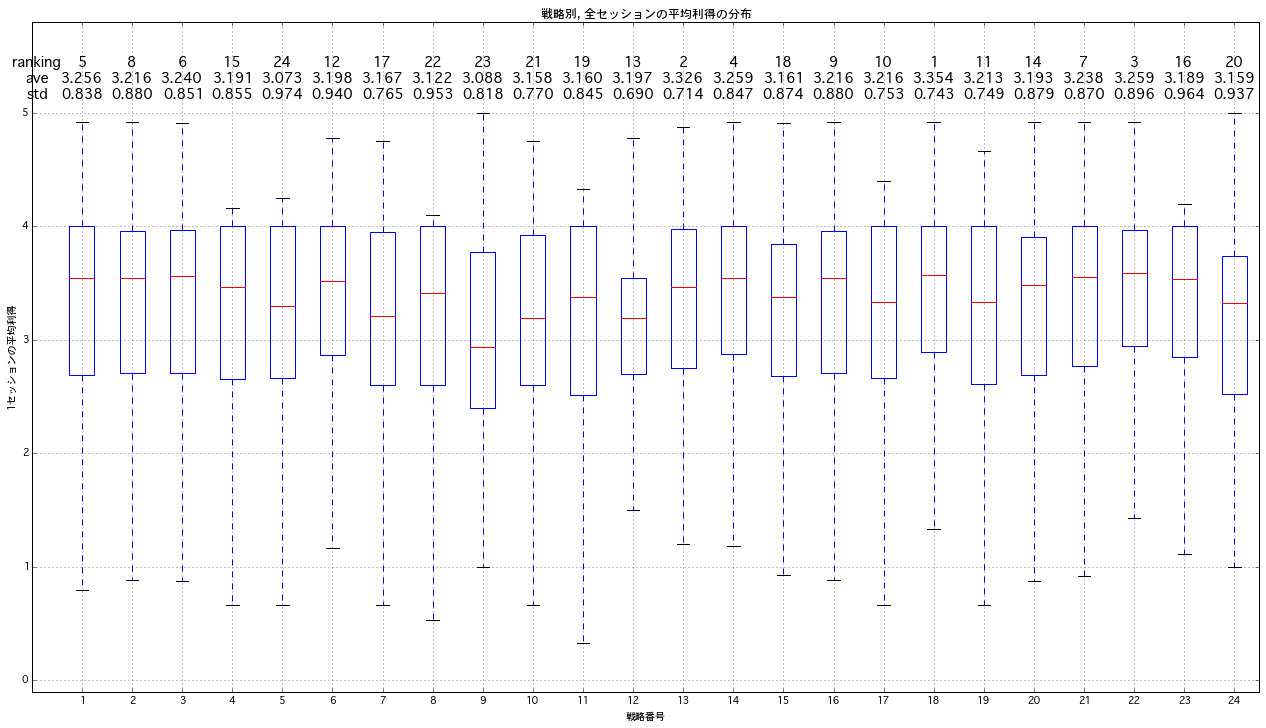

In [22]:
rounds = 1000 * 2
strategies = 24
max_ts = 100

# 読み込み
df = pd.read_csv('./contest4/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# 行: プレイヤー, 列: 1000*2セッション分の平均利得
average_matrix = np.zeros((rounds*(strategies-1), strategies), dtype=float)

for s in range(1, strategies+1):
    for i, opponent in enumerate(df[str(s)].columns.values):
        average_matrix[i*rounds:(i+1)*rounds, s-1] = df[str(s)][str(opponent)]

averages = np.zeros(strategies, dtype=float)
stds = np.zeros(strategies, dtype=float)
ranking = np.zeros(strategies, dtype=int)
for i in range(strategies):
    averages[i] = average_matrix[:, i].mean()
    stds[i] = average_matrix[:, i].std()
ranking = np.argsort(averages)[::-1]+1

fig, ax = plt.subplots(figsize=(22, 12))
bp = ax.boxplot(average_matrix, 0, '')
plt.grid()
plt.xlabel('戦略番号')
plt.ylabel('1セッションの平均利得')
ax.set_xlim([0, strategies+0.5])
ax.set_ylim([-0.1, 5.8])
plt.title('戦略別, 全セッションの平均利得の分布')
ax.text(0.1, 5.3, "ranking\nave\nstd", ha = 'center', va = 'center', color="black", size=14)
for i in range(strategies):
    ax.text(i+1, 5.3, "{0:.0f}\n{1:.3f}\n{2:.3f}"
            .format(np.where(ranking == i+1)[0][0]+1, averages[i], stds[i]), ha = 'center', va = 'center', color="black", size=14)

plt.show()

### 基本統計量

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				1
			</th>
			<th>
				2
			</th>
			<th>
				3
			</th>
			<th>
				4
			</th>
			<th>
				5
			</th>
			<th>
				6
			</th>
			<th>
				7
			</th>
			<th>
				8
			</th>
			<th>
				9
			</th>
			<th>
				10
			</th>
			<th>
				11
			</th>
			<th>
				12
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				ranking
			</th>
			<td>
				5
			</td>
			<td>
				8
			</td>
			<td>
				6
			</td>
			<td>
				15
			</td>
			<td>
				24
			</td>
			<td>
				12
			</td>
			<td>
				17
			</td>
			<td>
				22
			</td>
			<td>
				23
			</td>
			<td>
				21
			</td>
			<td>
				19
			</td>
			<td>
				13
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.256299
			</td>
			<td>
				3.215813
			</td>
			<td>
				3.240388
			</td>
			<td>
				3.191465
			</td>
			<td>
				3.072941
			</td>
			<td>
				3.197764
			</td>
			<td>
				3.166979
			</td>
			<td>
				3.12153
			</td>
			<td>
				3.08836
			</td>
			<td>
				3.157509
			</td>
			<td>
				3.159788
			</td>
			<td>
				3.197074
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.837516
			</td>
			<td>
				0.879935
			</td>
			<td>
				0.850714
			</td>
			<td>
				0.855328
			</td>
			<td>
				0.974213
			</td>
			<td>
				0.939815
			</td>
			<td>
				0.765376
			</td>
			<td>
				0.953146
			</td>
			<td>
				0.818489
			</td>
			<td>
				0.76951
			</td>
			<td>
				0.845308
			</td>
			<td>
				0.690475
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				1
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.694303
			</td>
			<td>
				2.705882
			</td>
			<td>
				2.704918
			</td>
			<td>
				2.658537
			</td>
			<td>
				2.666667
			</td>
			<td>
				2.864865
			</td>
			<td>
				2.6
			</td>
			<td>
				2.6
			</td>
			<td>
				2.4
			</td>
			<td>
				2.6
			</td>
			<td>
				2.515152
			</td>
			<td>
				2.7
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.548387
			</td>
			<td>
				3.541918
			</td>
			<td>
				3.5625
			</td>
			<td>
				3.466667
			</td>
			<td>
				3.303571
			</td>
			<td>
				3.52381
			</td>
			<td>
				3.210526
			</td>
			<td>
				3.416667
			</td>
			<td>
				2.9375
			</td>
			<td>
				3.195122
			</td>
			<td>
				3.378078
			</td>
			<td>
				3.194444
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				4
			</td>
			<td>
				3.964286
			</td>
			<td>
				3.969697
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.947368
			</td>
			<td>
				4
			</td>
			<td>
				3.777778
			</td>
			<td>
				3.923077
			</td>
			<td>
				4
			</td>
			<td>
				3.545455
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.923077
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.909091
			</td>
			<td>
				4.166667
			</td>
			<td>
				4.25
			</td>
			<td>
				4.777778
			</td>
			<td>
				4.75
			</td>
			<td>
				4.104895
			</td>
			<td>
				5
			</td>
			<td>
				4.75
			</td>
			<td>
				4.333333
			</td>
			<td>
				4.777778
			</td>
		</tr>
	</tbody>
</table>

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				13
			</th>
			<th>
				14
			</th>
			<th>
				15
			</th>
			<th>
				16
			</th>
			<th>
				17
			</th>
			<th>
				18
			</th>
			<th>
				19
			</th>
			<th>
				20
			</th>
			<th>
				21
			</th>
			<th>
				22
			</th>
			<th>
				23
			</th>
			<th>
				24
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				ranking
			</th>
			<td>
				2
			</td>
			<td>
				4
			</td>
			<td>
				18
			</td>
			<td>
				9
			</td>
			<td>
				10
			</td>
			<td>
				1
			</td>
			<td>
				11
			</td>
			<td>
				14
			</td>
			<td>
				7
			</td>
			<td>
				3
			</td>
			<td>
				16
			</td>
			<td>
				20
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
			<td>
				46000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.326308
			</td>
			<td>
				3.258887
			</td>
			<td>
				3.161226
			</td>
			<td>
				3.215813
			</td>
			<td>
				3.215548
			</td>
			<td>
				3.353524
			</td>
			<td>
				3.213335
			</td>
			<td>
				3.192768
			</td>
			<td>
				3.238405
			</td>
			<td>
				3.259069
			</td>
			<td>
				3.188569
			</td>
			<td>
				3.158549
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.714311
			</td>
			<td>
				0.847242
			</td>
			<td>
				0.874287
			</td>
			<td>
				0.879935
			</td>
			<td>
				0.753468
			</td>
			<td>
				0.742637
			</td>
			<td>
				0.748892
			</td>
			<td>
				0.878785
			</td>
			<td>
				0.870167
			</td>
			<td>
				0.896169
			</td>
			<td>
				0.963549
			</td>
			<td>
				0.937062
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				1
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.75
			</td>
			<td>
				2.875
			</td>
			<td>
				2.68265
			</td>
			<td>
				2.705882
			</td>
			<td>
				2.661578
			</td>
			<td>
				2.892204
			</td>
			<td>
				2.611111
			</td>
			<td>
				2.692308
			</td>
			<td>
				2.769231
			</td>
			<td>
				2.95
			</td>
			<td>
				2.846154
			</td>
			<td>
				2.522727
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.466667
			</td>
			<td>
				3.55
			</td>
			<td>
				3.375
			</td>
			<td>
				3.541918
			</td>
			<td>
				3.333333
			</td>
			<td>
				3.571429
			</td>
			<td>
				3.333333
			</td>
			<td>
				3.482759
			</td>
			<td>
				3.555556
			</td>
			<td>
				3.587932
			</td>
			<td>
				3.533333
			</td>
			<td>
				3.325581
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				3.97619
			</td>
			<td>
				4
			</td>
			<td>
				3.849486
			</td>
			<td>
				3.964286
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.909091
			</td>
			<td>
				4
			</td>
			<td>
				3.965517
			</td>
			<td>
				4
			</td>
			<td>
				3.742424
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.875
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.909091
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.4
			</td>
			<td>
				4.923077
			</td>
			<td>
				4.666667
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.2
			</td>
			<td>
				5
			</td>
		</tr>
	</tbody>
</table>

## 期数による平均利得の変化

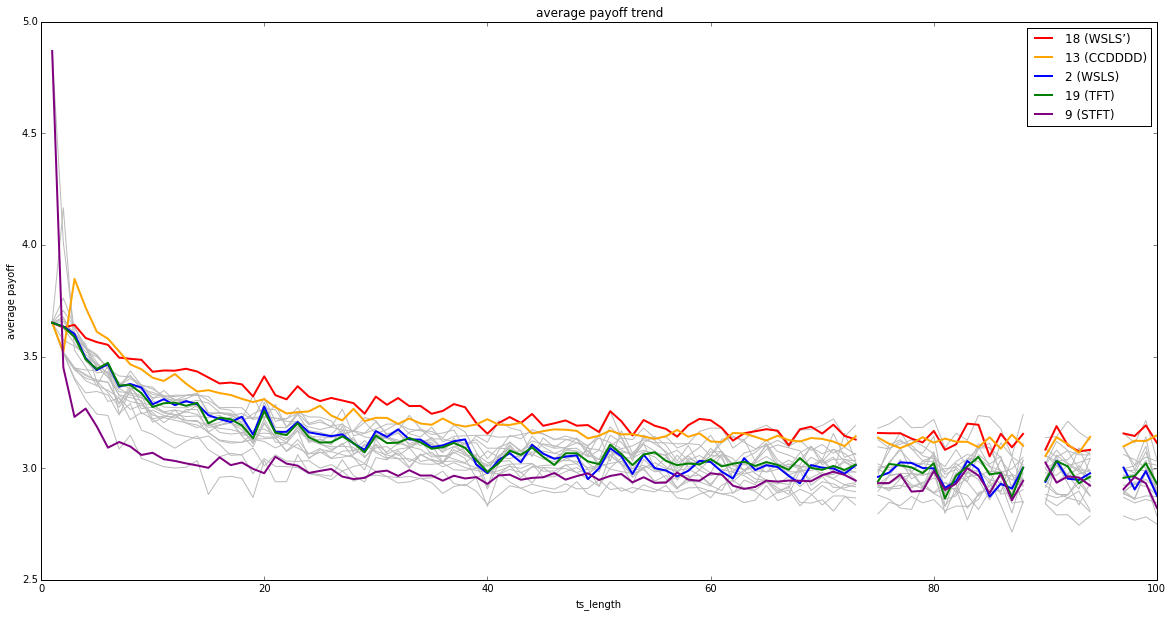

In [36]:
rounds = 1000 * 2
strategies = 24
max_ts = 100

# 読み込み
df = pd.read_csv('./contest4/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜100期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)

for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]
    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("average payoff trend")
plt.xlabel("ts_length")
plt.ylabel("average payoff")
t_list = [i for i in range(1, max_ts+1)]

for s in range(1, strategies+1):
    if s in [18, 13, 2, 19, 9]:
        pass
    else:
        average_list = average_matrix[s-1]
        plt.plot(t_list, average_list, color='#bbbbbb')

plt.plot(t_list, average_matrix[18-1], color='red', linewidth=2, label="18 (WSLS’)")
plt.plot(t_list, average_matrix[13-1], color='orange', linewidth=2, label="13 (CCDDDD)")
plt.plot(t_list, average_matrix[2-1], color='blue', linewidth=2, label="2 (WSLS)")
plt.plot(t_list, average_matrix[19-1], color='green', linewidth=2, label="19 (TFT)")
plt.plot(t_list, average_matrix[9-1], color='purple', linewidth=2, label="9 (STFT)")
plt.legend()
plt.show()

1位になったWSLS'（Strategy18）は、WSLSをよりALLDに強くしたもの（後述）。2位はALLD。  
Strategy18: ![Strategy18](./documents/wsls18.jpg)

## トリム平均

セッション・ベース平均から、期数の短いセッション・長いセッションそれぞれ5%ずつを除外して平均を求める  
※区間の端にタイがある場合は、重みを調整する（例: 48位: 1, 49位: 2, 50位: 2, 51位: 2, 52位: 3なら、49位〜51位の平均利得の和を1/3倍して計算する）

In [28]:
def trim_mean(ts_length, aves, width):
    size = ts_length.size
    hist = {}
    for t in ts_length:
        hist[t] = hist.get(t, 0) + 1

    lower_b = size * (1-width) / 2
    upper_b = size * (1 - (1-width)/2)

    s = 0
    total = 0
    for ts, num in sorted(hist.items()):
        old_s = s
        s += num
        if old_s <= lower_b < s:
            total += (s-lower_b) * aves[ts-1]

        elif old_s <= upper_b < s:
            total += (upper_b-old_s+1) * aves[ts-1]

        elif lower_b <= s <= upper_b:
            total += num * aves[ts-1]

        elif s > upper_b:
            break

    return total / (size * width)

rounds = 1000 * 2
strategies = 24
max_ts = ts_length.max()
    
# 読み込み
df = pd.read_csv('./contest4/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜max期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)
for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]
    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

for i in range(strategies):
    print(trim_mean(ts_length, average_matrix[i], 0.9))

3.25028511707
3.21096357851
3.23663967616
3.18188857519
3.06308019426
3.19319331055
3.15884430904
3.09671877158
3.03083932669
3.14890921282
3.15402173936
3.1780469466
3.32768294501
3.25616068341
3.15145888378
3.21096357851
3.21302083987
3.35422360163
3.20715433858
3.18669779767
3.23519375673
3.25493501108
3.18058918396
3.10146601311


<table>
	<thead>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(stage based)
			</th>
			<th>
				Average(90% trimmed)
			</th>
			<th>
				Rank(trimmed)
			</th>
			<th>
				備考
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				18
			</th>
			<td>
				3.35352416
			</td>
			<td>
				1
			</td>
			<td>
				3.219810292
			</td>
			<td>
				1
			</td>
			<td>
				3.354223602
			</td>
			<td>
				1
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				13
			</th>
			<td>
				3.326308014
			</td>
			<td>
				2
			</td>
			<td>
				3.182248494
			</td>
			<td>
				2
			</td>
			<td>
				3.327682945
			</td>
			<td>
				2
			</td>
			<td>
				CCDDDD
			</td>
		</tr>
		<tr>
			<th>
				22
			</th>
			<td>
				3.259068663
			</td>
			<td>
				3
			</td>
			<td>
				3.121244482
			</td>
			<td>
				5
			</td>
			<td>
				3.254935011
			</td>
			<td>
				4
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				14
			</th>
			<td>
				3.258886509
			</td>
			<td>
				4
			</td>
			<td>
				3.122727237
			</td>
			<td>
				4
			</td>
			<td>
				3.256160683
			</td>
			<td>
				3
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				3.256299103
			</td>
			<td>
				5
			</td>
			<td>
				3.132024724
			</td>
			<td>
				3
			</td>
			<td>
				3.250285117
			</td>
			<td>
				5
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				3.240387724
			</td>
			<td>
				6
			</td>
			<td>
				3.082433491
			</td>
			<td>
				9
			</td>
			<td>
				3.236639676
			</td>
			<td>
				6
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				21
			</th>
			<td>
				3.238405281
			</td>
			<td>
				7
			</td>
			<td>
				3.083776638
			</td>
			<td>
				8
			</td>
			<td>
				3.235193757
			</td>
			<td>
				7
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				3.215812884
			</td>
			<td>
				8
			</td>
			<td>
				3.054822228
			</td>
			<td>
				14
			</td>
			<td>
				3.210963579
			</td>
			<td>
				9
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				16
			</th>
			<td>
				3.215812884
			</td>
			<td>
				9
			</td>
			<td>
				3.054822228
			</td>
			<td>
				15
			</td>
			<td>
				3.210963579
			</td>
			<td>
				10
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				17
			</th>
			<td>
				3.215547504
			</td>
			<td>
				10
			</td>
			<td>
				3.063675088
			</td>
			<td>
				11
			</td>
			<td>
				3.21302084
			</td>
			<td>
				8
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				19
			</th>
			<td>
				3.213334955
			</td>
			<td>
				11
			</td>
			<td>
				3.06115156
			</td>
			<td>
				12
			</td>
			<td>
				3.207154339
			</td>
			<td>
				11
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				3.197763649
			</td>
			<td>
				12
			</td>
			<td>
				3.056192503
			</td>
			<td>
				13
			</td>
			<td>
				3.193193311
			</td>
			<td>
				12
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				12
			</th>
			<td>
				3.197073568
			</td>
			<td>
				13
			</td>
			<td>
				3.045809911
			</td>
			<td>
				16
			</td>
			<td>
				3.178046947
			</td>
			<td>
				16
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				20
			</th>
			<td>
				3.192768288
			</td>
			<td>
				14
			</td>
			<td>
				3.020367533
			</td>
			<td>
				17
			</td>
			<td>
				3.186697798
			</td>
			<td>
				13
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				3.191465329
			</td>
			<td>
				15
			</td>
			<td>
				3.086214152
			</td>
			<td>
				7
			</td>
			<td>
				3.181888575
			</td>
			<td>
				14
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				23
			</th>
			<td>
				3.188569289
			</td>
			<td>
				16
			</td>
			<td>
				3.06617612
			</td>
			<td>
				10
			</td>
			<td>
				3.180589184
			</td>
			<td>
				15
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				3.166979223
			</td>
			<td>
				17
			</td>
			<td>
				3.001625671
			</td>
			<td>
				19
			</td>
			<td>
				3.158844309
			</td>
			<td>
				17
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				15
			</th>
			<td>
				3.161225612
			</td>
			<td>
				18
			</td>
			<td>
				2.983885545
			</td>
			<td>
				21
			</td>
			<td>
				3.151458884
			</td>
			<td>
				19
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				11
			</th>
			<td>
				3.159787981
			</td>
			<td>
				19
			</td>
			<td>
				3.004255063
			</td>
			<td>
				18
			</td>
			<td>
				3.154021739
			</td>
			<td>
				18
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				24
			</th>
			<td>
				3.158548933
			</td>
			<td>
				20
			</td>
			<td>
				2.940998137
			</td>
			<td>
				23
			</td>
			<td>
				3.101466013
			</td>
			<td>
				21
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				3.157508886
			</td>
			<td>
				21
			</td>
			<td>
				2.988733446
			</td>
			<td>
				20
			</td>
			<td>
				3.148909213
			</td>
			<td>
				20
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				3.121529725
			</td>
			<td>
				22
			</td>
			<td>
				3.104081314
			</td>
			<td>
				6
			</td>
			<td>
				3.096718772
			</td>
			<td>
				22
			</td>
			<td>
				HIST
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				3.088360193
			</td>
			<td>
				23
			</td>
			<td>
				2.962527525
			</td>
			<td>
				22
			</td>
			<td>
				3.030839327
			</td>
			<td>
				24
			</td>
			<td>
				STFT
			</td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				3.072941197
			</td>
			<td>
				24
			</td>
			<td>
				2.902704555
			</td>
			<td>
				24
			</td>
			<td>
				3.063080194
			</td>
			<td>
				23
			</td>
			<td>
				
			</td>
		</tr>
	</tbody>
</table>

ほぼセッションベース平均と同じ。

# Case5: imperfect private monitoring（尾山ゼミ+神取ゼミの戦略）

結果の生データ(csv)は [contest5/data](./contest5/data)  
戦略は [user_strategies](./user_strategies)  
戦略のオートマトンは [contest5/automaton5.pdf](./contest5/automaton5.pdf)  

In [19]:
# 「相手の」シグナルが協調か攻撃かを（ノイズ付きで）返す
def private_signal(actions, random_state):
    pattern = [[0, 0], [0, 1], [1, 0], [1, 1]]
    # 例えば実際の行動が(0, 1)なら、シグナルは(1, 0)である可能性が最も高い
    signal_probs = [[.9, .02, .02, .06], [.02, .06, .9, .02], [.02, .9, .06, .02], [.06, .02, .02, .9]]
    p = random_state.uniform()
    if actions[0] == 0 and actions[1] == 0:
        return [0, 0] if p < 0.9 else [0, 1] if p < 0.92 else [1, 0] if p < 0.94 else [1, 1]
    elif actions[0] == 0 and actions[1] == 1:
        return [1, 0] if p < 0.9 else [0, 0] if p < 0.92 else [1, 1] if p < 0.94 else [0, 1]
    elif actions[0] == 1 and actions[1] == 0:
        return [0, 1] if p < 0.9 else [1, 1] if p < 0.92 else [0, 0] if p < 0.94 else [1, 0]
    elif actions[0] == 1 and actions[1] == 1:
        return [1, 1] if p < 0.9 else [1, 0] if p < 0.92 else [0, 1] if p < 0.94 else [0, 0]
    else:
        raise ValueError

strategies = [Strategy1, Strategy2, Strategy3, Strategy4, Strategy5,
                    Strategy6, Strategy7, Strategy8, Strategy9, Strategy10,
                    Strategy11, Strategy12, Strategy13, Strategy14, Strategy15,
                    Strategy16, Strategy17, Strategy18, Strategy19, Strategy20, 
                    Strategy21, Strategy22, Strategy23, Strategy24, 
                    Iida_iprm, KatoStrategy, Self_Centered_private, ImPrivStrategy,
                    GrimTrigger, MyStrategy, beeleb, OyamaImperfectPrivateMonitoring, ogawa, yamagishi]
    
game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)

Start
The object has 34 strategy functions below
--------------------------------------------------
1. kandori.Strategy1
2. kandori.Strategy2
3. kandori.Strategy3
4. kandori.Strategy4
5. kandori.Strategy5
6. kandori.Strategy6
7. kandori.Strategy7
8. kandori.Strategy8
9. kandori.Strategy9
10. kandori.Strategy10
11. kandori.Strategy11
12. kandori.Strategy12
13. kandori.Strategy13
14. kandori.Strategy14
15. kandori.Strategy15
16. kandori.Strategy16
17. kandori.Strategy17
18. kandori.Strategy18
19. kandori.Strategy19
20. kandori.Strategy20
21. kandori.Strategy21
22. kandori.Strategy22
23. kandori.Strategy23
24. kandori.Strategy24
25. Iida_imperfect_private.Iida_iprm
26. kato.KatoStrategy
27. ikegami_imperfect_private.Self_Centered_private
28. mhanami_Imperfect_Private_Strategy.ImPrivStrategy
29. tsuyoshi.GrimTrigger
30. gistfile1.MyStrategy
31. beeleb_Strategy.beeleb
32. oyama.OyamaImperfectPrivateMonitoring
33. ogawa.ogawa
34. yamagishi_impd.yamagishi
-------------------------------------

## Summary

<table>
	<tbody>
		<tr>
			<th>
				Datetime
			</th>
			<td colspan="6">
				2015-11-30-18-01-45
			</td>
		</tr>
		<tr>
			<th>
				Monitoring type
			</th>
			<td colspan="6">
				private
			</td>
		</tr>
		<tr>
			<th>
				RandomSeed
			</th>
			<td colspan="6">
				282
			</td>
		</tr>
		<tr>
			<th>
				Repeats
			</th>
			<td colspan="6">
				1000
			</td>
		</tr>
		<tr>
			<th>
				Average ts_length
			</th>
			<td colspan="6">
				32.856
			</td>
		</tr>
		<tr>
			<th>
				Number of strategies
			</th>
			<td colspan="6">
				34
			</td>
		</tr>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Strategy name
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(stage based)
			</th>
			<th>
				備考
			</th>
		</tr>
		<tr>
			<th>
				27
			</th>
			<td>
				ikegami_imperfect_private.Self_Centered_private
			</td>
			<td>
				3.36832832
			</td>
			<td>
				1
			</td>
			<td>
				3.220361024
			</td>
			<td>
				1
			</td>
			<td>
				20%
			</td>
		</tr>
		<tr>
			<th>
				28
			</th>
			<td>
				mhanami_Imperfect_Private_Strategy.ImPrivStrategy
			</td>
			<td>
				3.348553889
			</td>
			<td>
				2
			</td>
			<td>
				3.216393297
			</td>
			<td>
				2
			</td>
			<td>
				2T2FT
			</td>
		</tr>
		<tr>
			<th>
				25
			</th>
			<td>
				Iida_imperfect_private.Iida_iprm
			</td>
			<td>
				3.32968985
			</td>
			<td>
				3
			</td>
			<td>
				3.15335652
			</td>
			<td>
				5
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				18
			</th>
			<td>
				kandori.Strategy18
			</td>
			<td>
				3.292214224
			</td>
			<td>
				4
			</td>
			<td>
				3.084777652
			</td>
			<td>
				15
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				17
			</th>
			<td>
				kandori.Strategy17
			</td>
			<td>
				3.283194443
			</td>
			<td>
				5
			</td>
			<td>
				3.11118305
			</td>
			<td>
				8
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				kandori.Strategy4
			</td>
			<td>
				3.282928401
			</td>
			<td>
				6
			</td>
			<td>
				3.158213803
			</td>
			<td>
				4
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				19
			</th>
			<td>
				kandori.Strategy19
			</td>
			<td>
				3.277143381
			</td>
			<td>
				7
			</td>
			<td>
				3.106785994
			</td>
			<td>
				10
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				34
			</th>
			<td>
				yamagishi_impd.yamagishi
			</td>
			<td>
				3.277143381
			</td>
			<td>
				8
			</td>
			<td>
				3.106785994
			</td>
			<td>
				11
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				30
			</th>
			<td>
				gistfile1.MyStrategy
			</td>
			<td>
				3.266900169
			</td>
			<td>
				9
			</td>
			<td>
				3.116454907
			</td>
			<td>
				7
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				29
			</th>
			<td>
				tsuyoshi.GrimTrigger
			</td>
			<td>
				3.26353101
			</td>
			<td>
				10
			</td>
			<td>
				3.085325036
			</td>
			<td>
				14
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				kandori.Strategy1
			</td>
			<td>
				3.261856949
			</td>
			<td>
				11
			</td>
			<td>
				3.076891541
			</td>
			<td>
				17
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				23
			</th>
			<td>
				kandori.Strategy23
			</td>
			<td>
				3.261667595
			</td>
			<td>
				12
			</td>
			<td>
				3.107009651
			</td>
			<td>
				9
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				11
			</th>
			<td>
				kandori.Strategy11
			</td>
			<td>
				3.260228791
			</td>
			<td>
				13
			</td>
			<td>
				3.098884204
			</td>
			<td>
				12
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				32
			</th>
			<td>
				oyama.OyamaImperfectPrivateMonitoring
			</td>
			<td>
				3.255871528
			</td>
			<td>
				14
			</td>
			<td>
				3.087366082
			</td>
			<td>
				13
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				14
			</th>
			<td>
				kandori.Strategy14
			</td>
			<td>
				3.25337761
			</td>
			<td>
				15
			</td>
			<td>
				3.058440504
			</td>
			<td>
				18
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				33
			</th>
			<td>
				ogawa.ogawa
			</td>
			<td>
				3.247716335
			</td>
			<td>
				16
			</td>
			<td>
				3.083111982
			</td>
			<td>
				16
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				31
			</th>
			<td>
				beeleb_Strategy.beeleb
			</td>
			<td>
				3.245998144
			</td>
			<td>
				17
			</td>
			<td>
				3.117079764
			</td>
			<td>
				6
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				kandori.Strategy8
			</td>
			<td>
				3.239536248
			</td>
			<td>
				18
			</td>
			<td>
				3.180036763
			</td>
			<td>
				3
			</td>
			<td>
				HIST
			</td>
		</tr>
		<tr>
			<th>
				22
			</th>
			<td>
				kandori.Strategy22
			</td>
			<td>
				3.231422435
			</td>
			<td>
				19
			</td>
			<td>
				3.033872324
			</td>
			<td>
				20
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				kandori.Strategy6
			</td>
			<td>
				3.225318551
			</td>
			<td>
				20
			</td>
			<td>
				3.030270289
			</td>
			<td>
				22
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				kandori.Strategy7
			</td>
			<td>
				3.225300065
			</td>
			<td>
				21
			</td>
			<td>
				3.037891239
			</td>
			<td>
				19
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				13
			</th>
			<td>
				kandori.Strategy13
			</td>
			<td>
				3.223658906
			</td>
			<td>
				22
			</td>
			<td>
				3.020115324
			</td>
			<td>
				24
			</td>
			<td>
				CCDDDD
			</td>
		</tr>
		<tr>
			<th>
				21
			</th>
			<td>
				kandori.Strategy21
			</td>
			<td>
				3.216136749
			</td>
			<td>
				23
			</td>
			<td>
				2.999892552
			</td>
			<td>
				25
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				kandori.Strategy10
			</td>
			<td>
				3.214150715
			</td>
			<td>
				24
			</td>
			<td>
				3.022255517
			</td>
			<td>
				23
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				kandori.Strategy3
			</td>
			<td>
				3.207011964
			</td>
			<td>
				25
			</td>
			<td>
				2.984919502
			</td>
			<td>
				27
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				26
			</th>
			<td>
				kato.KatoStrategy
			</td>
			<td>
				3.193996582
			</td>
			<td>
				26
			</td>
			<td>
				3.032555744
			</td>
			<td>
				21
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				16
			</th>
			<td>
				kandori.Strategy16
			</td>
			<td>
				3.186837934
			</td>
			<td>
				27
			</td>
			<td>
				2.962482753
			</td>
			<td>
				29
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				kandori.Strategy2
			</td>
			<td>
				3.186837934
			</td>
			<td>
				28
			</td>
			<td>
				2.962482753
			</td>
			<td>
				30
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				12
			</th>
			<td>
				kandori.Strategy12
			</td>
			<td>
				3.182024045
			</td>
			<td>
				29
			</td>
			<td>
				2.98471429
			</td>
			<td>
				28
			</td>
         <td></td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				kandori.Strategy5
			</td>
			<td>
				3.151694623
			</td>
			<td>
				30
			</td>
			<td>
				2.947040253
			</td>
			<td>
				31
			</td>
			<td></td>
		</tr>
		<tr>
			<th>
				20
			</th>
			<td>
				kandori.Strategy20
			</td>
			<td>
				3.149316992
			</td>
			<td>
				31
			</td>
			<td>
				2.918115136
			</td>
			<td>
				32
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				kandori.Strategy9
			</td>
			<td>
				3.131695859
			</td>
			<td>
				32
			</td>
			<td>
				2.986149848
			</td>
			<td>
				26
			</td>
			<td>
				STFT
			</td>
		</tr>
		<tr>
			<th>
				15
			</th>
			<td>
				kandori.Strategy15
			</td>
			<td>
				3.118259636
			</td>
			<td>
				33
			</td>
			<td>
				2.886726561
			</td>
			<td>
				33
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				24
			</th>
			<td>
				kandori.Strategy24
			</td>
			<td>
				3.017841689
			</td>
			<td>
				34
			</td>
			<td>
				2.754503121
			</td>
			<td>
				34
			</td>
			<td></td>
		</tr>
	</tbody>
</table>

## 戦略別, セッション平均の分布

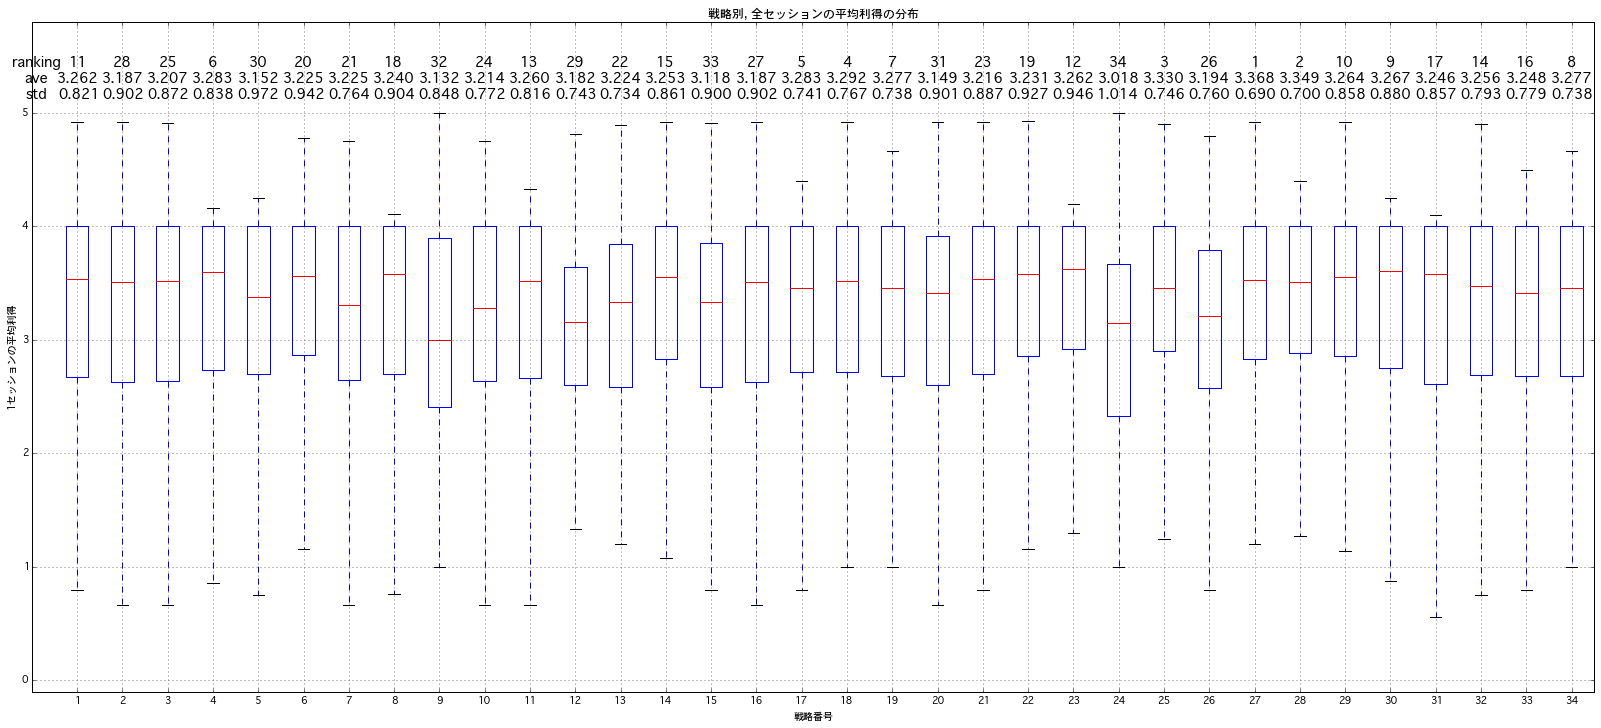

In [24]:
rounds = 1000 * 2
strategies = 34
max_ts = 100

# 読み込み
df = pd.read_csv('./contest5/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# 行: プレイヤー, 列: 1000*2セッション分の平均利得
average_matrix = np.zeros((rounds*(strategies-1), strategies), dtype=float)

for s in range(1, strategies+1):
    for i, opponent in enumerate(df[str(s)].columns.values):
        average_matrix[i*rounds:(i+1)*rounds, s-1] = df[str(s)][str(opponent)]

averages = np.zeros(strategies, dtype=float)
stds = np.zeros(strategies, dtype=float)
ranking = np.zeros(strategies, dtype=int)
for i in range(strategies):
    averages[i] = average_matrix[:, i].mean()
    stds[i] = average_matrix[:, i].std()
ranking = np.argsort(averages)[::-1]+1

fig, ax = plt.subplots(figsize=(28, 12))
bp = ax.boxplot(average_matrix, 0, '')
plt.grid()
plt.xlabel('戦略番号')
plt.ylabel('1セッションの平均利得')
ax.set_xlim([0, strategies+0.5])
ax.set_ylim([-0.1, 5.8])
plt.title('戦略別, 全セッションの平均利得の分布')
ax.text(0.1, 5.3, "ranking\nave\nstd", ha = 'center', va = 'center', color="black", size=14)
for i in range(strategies):
    ax.text(i+1, 5.3, "{0:.0f}\n{1:.3f}\n{2:.3f}"
            .format(np.where(ranking == i+1)[0][0]+1, averages[i], stds[i]), ha = 'center', va = 'center', color="black", size=14)

plt.show()

### 基本統計量

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				1
			</th>
			<th>
				2
			</th>
			<th>
				3
			</th>
			<th>
				4
			</th>
			<th>
				5
			</th>
			<th>
				6
			</th>
			<th>
				7
			</th>
			<th>
				8
			</th>
			<th>
				9
			</th>
			<th>
				10
			</th>
			<th>
				11
			</th>
			<th>
				12
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				rank
			</th>
			<td>
				11
			</td>
			<td>
				28
			</td>
			<td>
				25
			</td>
			<td>
				6
			</td>
			<td>
				30
			</td>
			<td>
				20
			</td>
			<td>
				21
			</td>
			<td>
				18
			</td>
			<td>
				32
			</td>
			<td>
				24
			</td>
			<td>
				13
			</td>
			<td>
				29
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.261857
			</td>
			<td>
				3.186838
			</td>
			<td>
				3.207012
			</td>
			<td>
				3.282928
			</td>
			<td>
				3.151695
			</td>
			<td>
				3.225319
			</td>
			<td>
				3.2253
			</td>
			<td>
				3.239536
			</td>
			<td>
				3.131696
			</td>
			<td>
				3.214151
			</td>
			<td>
				3.260229
			</td>
			<td>
				3.182024
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.820985
			</td>
			<td>
				0.901844
			</td>
			<td>
				0.871601
			</td>
			<td>
				0.838379
			</td>
			<td>
				0.971843
			</td>
			<td>
				0.941597
			</td>
			<td>
				0.764253
			</td>
			<td>
				0.904268
			</td>
			<td>
				0.847703
			</td>
			<td>
				0.771735
			</td>
			<td>
				0.815696
			</td>
			<td>
				0.743275
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				1
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.67681
			</td>
			<td>
				2.627406
			</td>
			<td>
				2.638741
			</td>
			<td>
				2.736842
			</td>
			<td>
				2.7
			</td>
			<td>
				2.863481
			</td>
			<td>
				2.650262
			</td>
			<td>
				2.701754
			</td>
			<td>
				2.407407
			</td>
			<td>
				2.638889
			</td>
			<td>
				2.666667
			</td>
			<td>
				2.6
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.535401
			</td>
			<td>
				3.514286
			</td>
			<td>
				3.52
			</td>
			<td>
				3.6
			</td>
			<td>
				3.375
			</td>
			<td>
				3.56697
			</td>
			<td>
				3.309091
			</td>
			<td>
				3.578947
			</td>
			<td>
				3
			</td>
			<td>
				3.285714
			</td>
			<td>
				3.51835
			</td>
			<td>
				3.16
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.894737
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.641026
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.923077
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.909091
			</td>
			<td>
				4.166667
			</td>
			<td>
				4.25
			</td>
			<td>
				4.777778
			</td>
			<td>
				4.75
			</td>
			<td>
				4.111111
			</td>
			<td>
				5
			</td>
			<td>
				4.75
			</td>
			<td>
				4.333333
			</td>
			<td>
				4.818182
			</td>
		</tr>
	</tbody>
</table>

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				13
			</th>
			<th>
				14
			</th>
			<th>
				15
			</th>
			<th>
				16
			</th>
			<th>
				17
			</th>
			<th>
				18
			</th>
			<th>
				19
			</th>
			<th>
				20
			</th>
			<th>
				21
			</th>
			<th>
				22
			</th>
			<th>
				23
			</th>
			<th>
				24
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				rank
			</th>
			<td>
				22
			</td>
			<td>
				15
			</td>
			<td>
				33
			</td>
			<td>
				27
			</td>
			<td>
				5
			</td>
			<td>
				4
			</td>
			<td>
				7
			</td>
			<td>
				31
			</td>
			<td>
				23
			</td>
			<td>
				19
			</td>
			<td>
				12
			</td>
			<td>
				34
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.223659
			</td>
			<td>
				3.253378
			</td>
			<td>
				3.11826
			</td>
			<td>
				3.186838
			</td>
			<td>
				3.283194
			</td>
			<td>
				3.292214
			</td>
			<td>
				3.277143
			</td>
			<td>
				3.149317
			</td>
			<td>
				3.216137
			</td>
			<td>
				3.231422
			</td>
			<td>
				3.261668
			</td>
			<td>
				3.017842
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.734062
			</td>
			<td>
				0.861139
			</td>
			<td>
				0.900098
			</td>
			<td>
				0.901844
			</td>
			<td>
				0.741322
			</td>
			<td>
				0.766913
			</td>
			<td>
				0.738413
			</td>
			<td>
				0.90132
			</td>
			<td>
				0.886843
			</td>
			<td>
				0.927439
			</td>
			<td>
				0.946034
			</td>
			<td>
				1.013924
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				1
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.583333
			</td>
			<td>
				2.833333
			</td>
			<td>
				2.585366
			</td>
			<td>
				2.627406
			</td>
			<td>
				2.714286
			</td>
			<td>
				2.72093
			</td>
			<td>
				2.681818
			</td>
			<td>
				2.6
			</td>
			<td>
				2.703019
			</td>
			<td>
				2.861538
			</td>
			<td>
				2.918919
			</td>
			<td>
				2.333333
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.333333
			</td>
			<td>
				3.555556
			</td>
			<td>
				3.333333
			</td>
			<td>
				3.514286
			</td>
			<td>
				3.457143
			</td>
			<td>
				3.520833
			</td>
			<td>
				3.454545
			</td>
			<td>
				3.416667
			</td>
			<td>
				3.538462
			</td>
			<td>
				3.578947
			</td>
			<td>
				3.627451
			</td>
			<td>
				3.153846
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				3.85
			</td>
			<td>
				4
			</td>
			<td>
				3.857143
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.916667
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				3.666667
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.894737
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.909091
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.4
			</td>
			<td>
				4.923077
			</td>
			<td>
				4.666667
			</td>
			<td>
				4.916667
			</td>
			<td>
				4.923077
			</td>
			<td>
				4.933333
			</td>
			<td>
				4.2
			</td>
			<td>
				5
			</td>
		</tr>
	</tbody>
</table>

<table>
	<thead>
		<tr>
			<th>
				str number
			</th>
			<th>
				25
			</th>
			<th>
				26
			</th>
			<th>
				27
			</th>
			<th>
				28
			</th>
			<th>
				29
			</th>
			<th>
				30
			</th>
			<th>
				31
			</th>
			<th>
				32
			</th>
			<th>
				33
			</th>
			<th>
				34
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				rank
			</th>
			<td>
				3
			</td>
			<td>
				26
			</td>
			<td>
				1
			</td>
			<td>
				2
			</td>
			<td>
				10
			</td>
			<td>
				9
			</td>
			<td>
				17
			</td>
			<td>
				14
			</td>
			<td>
				16
			</td>
			<td>
				8
			</td>
		</tr>
		<tr>
			<th>
				count
			</th>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
			<td>
				66000
			</td>
		</tr>
		<tr>
			<th>
				mean
			</th>
			<td>
				3.32969
			</td>
			<td>
				3.193997
			</td>
			<td>
				3.368328
			</td>
			<td>
				3.348554
			</td>
			<td>
				3.263531
			</td>
			<td>
				3.2669
			</td>
			<td>
				3.245998
			</td>
			<td>
				3.255872
			</td>
			<td>
				3.247716
			</td>
			<td>
				3.277143
			</td>
		</tr>
		<tr>
			<th>
				std
			</th>
			<td>
				0.746131
			</td>
			<td>
				0.760182
			</td>
			<td>
				0.690123
			</td>
			<td>
				0.700335
			</td>
			<td>
				0.857724
			</td>
			<td>
				0.879561
			</td>
			<td>
				0.856646
			</td>
			<td>
				0.793313
			</td>
			<td>
				0.779358
			</td>
			<td>
				0.738413
			</td>
		</tr>
		<tr>
			<th>
				min
			</th>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
			<td>
				0
			</td>
		</tr>
		<tr>
			<th>
				25%
			</th>
			<td>
				2.9
			</td>
			<td>
				2.577778
			</td>
			<td>
				2.829268
			</td>
			<td>
				2.888889
			</td>
			<td>
				2.857143
			</td>
			<td>
				2.75
			</td>
			<td>
				2.608696
			</td>
			<td>
				2.692308
			</td>
			<td>
				2.680851
			</td>
			<td>
				2.681818
			</td>
		</tr>
		<tr>
			<th>
				50%
			</th>
			<td>
				3.458333
			</td>
			<td>
				3.214286
			</td>
			<td>
				3.531915
			</td>
			<td>
				3.507692
			</td>
			<td>
				3.555556
			</td>
			<td>
				3.604167
			</td>
			<td>
				3.58209
			</td>
			<td>
				3.47619
			</td>
			<td>
				3.41791
			</td>
			<td>
				3.454545
			</td>
		</tr>
		<tr>
			<th>
				75%
			</th>
			<td>
				4
			</td>
			<td>
				3.794118
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
			<td>
				4
			</td>
		</tr>
		<tr>
			<th>
				max
			</th>
			<td>
				4.9
			</td>
			<td>
				4.8
			</td>
			<td>
				4.923077
			</td>
			<td>
				4.4
			</td>
			<td>
				4.923077
			</td>
			<td>
				4.25
			</td>
			<td>
				4.1
			</td>
			<td>
				4.9
			</td>
			<td>
				4.5
			</td>
			<td>
				4.666667
			</td>
		</tr>
	</tbody>
</table>

## 期数による平均利得の変化

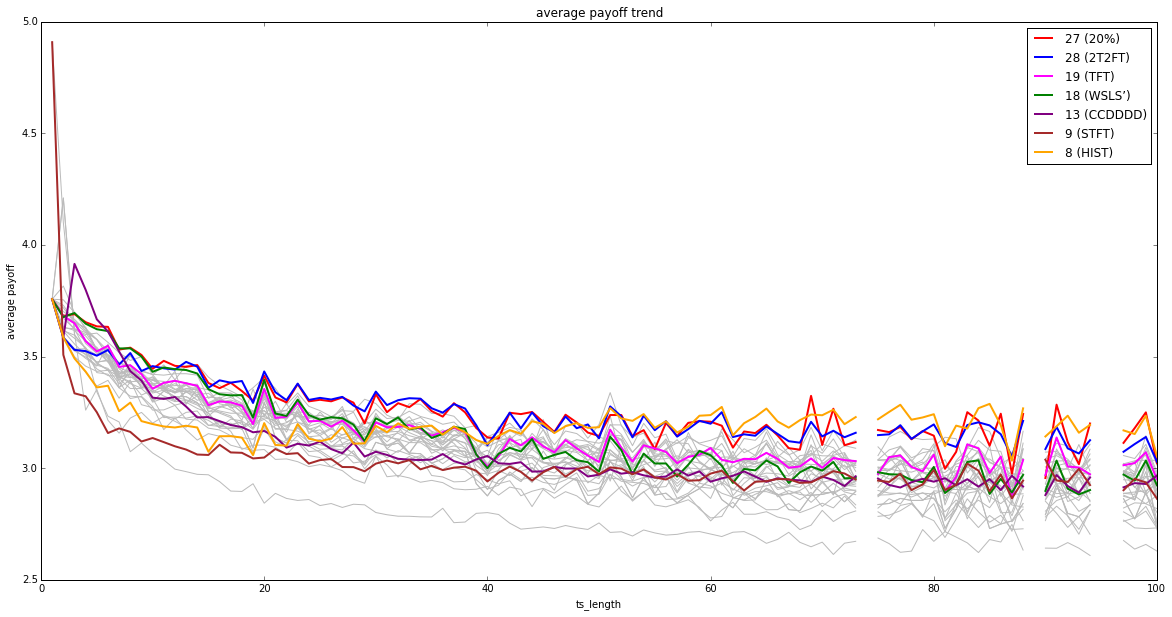

In [39]:
rounds = 1000 * 2
strategies = 34
max_ts = 100

# 読み込み
df = pd.read_csv('./contest5/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜100期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)

for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]

    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("average payoff trend")
plt.xlabel("ts_length")
plt.ylabel("average payoff")
t_list = [i for i in range(1, max_ts+1)]

for s in range(1, strategies+1):
    if s in [27, 28, 18, 13, 9, 8]:
        pass
    else:
        average_list = average_matrix[s-1]
        plt.plot(t_list, average_list, color='#bbbbbb')

plt.plot(t_list, average_matrix[27-1], color='red', linewidth=2, label="27 (20%)")
plt.plot(t_list, average_matrix[28-1], color='blue', linewidth=2, label="28 (2T2FT)")
plt.plot(t_list, average_matrix[19-1], color='magenta', linewidth=2, label="19 (TFT)")
plt.plot(t_list, average_matrix[18-1], color='green', linewidth=2, label="18 (WSLS’)")
plt.plot(t_list, average_matrix[13-1], color='purple', linewidth=2, label="13 (CCDDDD)")
plt.plot(t_list, average_matrix[9-1], color='brown', linewidth=2, label="9 (STFT)")
plt.plot(t_list, average_matrix[8-1], color='orange', linewidth=2, label="8 (HIST)")

plt.legend()
plt.show()

## トリム平均

セッション・ベース平均から、期数の短いセッション・長いセッションそれぞれ5%ずつを除外して平均を求める

In [27]:
def trim_mean(ts_length, aves, width):
    size = ts_length.size
    hist = {}
    for t in ts_length:
        hist[t] = hist.get(t, 0) + 1

    lower_b = size * (1-width) / 2
    upper_b = size * (1 - (1-width)/2)

    s = 0
    total = 0
    for ts, num in sorted(hist.items()):
        old_s = s
        s += num
        if old_s <= lower_b < s:
            total += (s-lower_b) * aves[ts-1]

        elif old_s <= upper_b < s:
            total += (upper_b-old_s+1) * aves[ts-1]

        elif lower_b <= s <= upper_b:
            total += num * aves[ts-1]

        elif s > upper_b:
            break

    return total / (size * width)


rounds = 1000 * 2
strategies = 34
max_ts = ts_length.max()
    
# 読み込み
df = pd.read_csv('./contest5/data/set_result.csv', index_col=[0, 1], header=[0, 1])

# ts_lengthの長い順に並び替え
ordered_df = df.sortlevel(level="ts_length")

# 行: プレイヤー, 列: ts_lengthが1〜max期の時の平均利得
average_matrix = np.zeros((strategies, max_ts), dtype=float)
for t in range(1, max_ts+1):
    df_t = df.iloc[df.index.get_level_values('ts_length') == t]
    for s in range(1, strategies+1):
        average = df_t[str(s)].mean().mean()
        average_matrix[s-1, t-1] = average

for i in range(strategies):
    print(trim_mean(ts_length, average_matrix[i], 0.9))

3.25836725707
3.18221523428
3.20307270078
3.27601772122
3.14555469052
3.22311223864
3.21824876442
3.2229728734
3.07622321391
3.20662985621
3.25599931942
3.16186412531
3.21869016874
3.25197005584
3.10642827444
3.18221523428
3.28166651639
3.29192924383
3.2717703079
3.14148753929
3.21351405913
3.22710146175
3.25718310891
2.95367429804
3.33064159671
3.17322680745
3.36569290401
3.34637606734
3.26061739471
3.261474645
3.23668854089
3.25168590556
3.24281557534
3.2717703079


<table>
	<thead>
		<tr>
			<th>
				Str_numbers
			</th>
			<th>
				Avarage(session based)
			</th>
			<th>
				Rank(session based)
			</th>
			<th>
				Avarage(stage based)
			</th>
			<th>
				Rank(stage based)
			</th>
			<th>
				Average(90% trimmed)
			</th>
			<th>
				Rank(trimmed)
			</th>
			<th>
				備考
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				27
			</th>
			<td>
				3.368 
			</td>
			<td>
				1
			</td>
			<td>
				3.220 
			</td>
			<td>
				1
			</td>
			<td>
				3.366 
			</td>
			<td>
				1
			</td>
			<td>
				20%
			</td>
		</tr>
		<tr>
			<th>
				28
			</th>
			<td>
				3.349 
			</td>
			<td>
				2
			</td>
			<td>
				3.216 
			</td>
			<td>
				2
			</td>
			<td>
				3.346 
			</td>
			<td>
				2
			</td>
			<td>
				2T2FT
			</td>
		</tr>
		<tr>
			<th>
				25
			</th>
			<td>
				3.330 
			</td>
			<td>
				3
			</td>
			<td>
				3.153 
			</td>
			<td>
				5
			</td>
			<td>
				3.331 
			</td>
			<td>
				3
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				18
			</th>
			<td>
				3.292 
			</td>
			<td>
				4
			</td>
			<td>
				3.085 
			</td>
			<td>
				15
			</td>
			<td>
				3.292 
			</td>
			<td>
				4
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				17
			</th>
			<td>
				3.283 
			</td>
			<td>
				5
			</td>
			<td>
				3.111 
			</td>
			<td>
				8
			</td>
			<td>
				3.282 
			</td>
			<td>
				5
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				4
			</th>
			<td>
				3.283 
			</td>
			<td>
				6
			</td>
			<td>
				3.158 
			</td>
			<td>
				4
			</td>
			<td>
				3.276 
			</td>
			<td>
				6
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				19
			</th>
			<td>
				3.277 
			</td>
			<td>
				7
			</td>
			<td>
				3.107 
			</td>
			<td>
				10
			</td>
			<td>
				3.272 
			</td>
			<td>
				8
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				34
			</th>
			<td>
				3.277 
			</td>
			<td>
				8
			</td>
			<td>
				3.107 
			</td>
			<td>
				11
			</td>
			<td>
				3.272 
			</td>
			<td>
				7
			</td>
			<td>
				TFT
			</td>
		</tr>
		<tr>
			<th>
				30
			</th>
			<td>
				3.267 
			</td>
			<td>
				9
			</td>
			<td>
				3.116 
			</td>
			<td>
				7
			</td>
			<td>
				3.261 
			</td>
			<td>
				9
			</td>
			<td>
				2TFT'
			</td>
		</tr>
		<tr>
			<th>
				29
			</th>
			<td>
				3.264 
			</td>
			<td>
				10
			</td>
			<td>
				3.085 
			</td>
			<td>
				14
			</td>
			<td>
				3.261 
			</td>
			<td>
				10
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				1
			</th>
			<td>
				3.262 
			</td>
			<td>
				11
			</td>
			<td>
				3.077 
			</td>
			<td>
				17
			</td>
			<td>
				3.258 
			</td>
			<td>
				11
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				23
			</th>
			<td>
				3.262 
			</td>
			<td>
				12
			</td>
			<td>
				3.107 
			</td>
			<td>
				9
			</td>
			<td>
				3.257 
			</td>
			<td>
				12
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				11
			</th>
			<td>
				3.260 
			</td>
			<td>
				13
			</td>
			<td>
				3.099 
			</td>
			<td>
				12
			</td>
			<td>
				3.256 
			</td>
			<td>
				13
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				32
			</th>
			<td>
				3.256 
			</td>
			<td>
				14
			</td>
			<td>
				3.087 
			</td>
			<td>
				13
			</td>
			<td>
				3.252 
			</td>
			<td>
				15
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				14
			</th>
			<td>
				3.253 
			</td>
			<td>
				15
			</td>
			<td>
				3.058 
			</td>
			<td>
				18
			</td>
			<td>
				3.252 
			</td>
			<td>
				14
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				33
			</th>
			<td>
				3.248 
			</td>
			<td>
				16
			</td>
			<td>
				3.083 
			</td>
			<td>
				16
			</td>
			<td>
				3.243 
			</td>
			<td>
				16
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				31
			</th>
			<td>
				3.246 
			</td>
			<td>
				17
			</td>
			<td>
				3.117 
			</td>
			<td>
				6
			</td>
			<td>
				3.237 
			</td>
			<td>
				17
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				8
			</th>
			<td>
				3.240 
			</td>
			<td>
				18
			</td>
			<td>
				3.180 
			</td>
			<td>
				3
			</td>
			<td>
				3.223 
			</td>
			<td>
				20
			</td>
			<td>
				HIST
			</td>
		</tr>
		<tr>
			<th>
				22
			</th>
			<td>
				3.231 
			</td>
			<td>
				19
			</td>
			<td>
				3.034 
			</td>
			<td>
				20
			</td>
			<td>
				3.227 
			</td>
			<td>
				18
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				6
			</th>
			<td>
				3.225 
			</td>
			<td>
				20
			</td>
			<td>
				3.030 
			</td>
			<td>
				22
			</td>
			<td>
				3.223 
			</td>
			<td>
				19
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				7
			</th>
			<td>
				3.225 
			</td>
			<td>
				21
			</td>
			<td>
				3.038 
			</td>
			<td>
				19
			</td>
			<td>
				3.218 
			</td>
			<td>
				22
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				13
			</th>
			<td>
				3.224 
			</td>
			<td>
				22
			</td>
			<td>
				3.020 
			</td>
			<td>
				24
			</td>
			<td>
				3.219 
			</td>
			<td>
				21
			</td>
			<td>
				CCDDDD
			</td>
		</tr>
		<tr>
			<th>
				21
			</th>
			<td>
				3.216 
			</td>
			<td>
				23
			</td>
			<td>
				3.000 
			</td>
			<td>
				25
			</td>
			<td>
				3.214 
			</td>
			<td>
				23
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				10
			</th>
			<td>
				3.214 
			</td>
			<td>
				24
			</td>
			<td>
				3.022 
			</td>
			<td>
				23
			</td>
			<td>
				3.207 
			</td>
			<td>
				24
			</td>
			<td>
				TFT'
			</td>
		</tr>
		<tr>
			<th>
				3
			</th>
			<td>
				3.207 
			</td>
			<td>
				25
			</td>
			<td>
				2.985 
			</td>
			<td>
				27
			</td>
			<td>
				3.203 
			</td>
			<td>
				25
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				26
			</th>
			<td>
				3.194 
			</td>
			<td>
				26
			</td>
			<td>
				3.033 
			</td>
			<td>
				21
			</td>
			<td>
				3.173 
			</td>
			<td>
				28
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				16
			</th>
			<td>
				3.187 
			</td>
			<td>
				27
			</td>
			<td>
				2.962 
			</td>
			<td>
				29
			</td>
			<td>
				3.182 
			</td>
			<td>
				27
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				2
			</th>
			<td>
				3.187 
			</td>
			<td>
				28
			</td>
			<td>
				2.962 
			</td>
			<td>
				30
			</td>
			<td>
				3.182 
			</td>
			<td>
				26
			</td>
			<td>
				WSLS
			</td>
		</tr>
		<tr>
			<th>
				12
			</th>
			<td>
				3.182 
			</td>
			<td>
				29
			</td>
			<td>
				2.985 
			</td>
			<td>
				28
			</td>
			<td>
				3.162 
			</td>
			<td>
				29
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				5
			</th>
			<td>
				3.152 
			</td>
			<td>
				30
			</td>
			<td>
				2.947 
			</td>
			<td>
				31
			</td>
			<td>
				3.146 
			</td>
			<td>
				30
			</td>
			<td>
				
			</td>
		</tr>
		<tr>
			<th>
				20
			</th>
			<td>
				3.149 
			</td>
			<td>
				31
			</td>
			<td>
				2.918 
			</td>
			<td>
				32
			</td>
			<td>
				3.141 
			</td>
			<td>
				31
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				9
			</th>
			<td>
				3.132 
			</td>
			<td>
				32
			</td>
			<td>
				2.986 
			</td>
			<td>
				26
			</td>
			<td>
				3.076 
			</td>
			<td>
				33
			</td>
			<td>
				STFT
			</td>
		</tr>
		<tr>
			<th>
				15
			</th>
			<td>
				3.118 
			</td>
			<td>
				33
			</td>
			<td>
				2.887 
			</td>
			<td>
				33
			</td>
			<td>
				3.106 
			</td>
			<td>
				32
			</td>
			<td>
				WSLS'
			</td>
		</tr>
		<tr>
			<th>
				24
			</th>
			<td>
				3.018 
			</td>
			<td>
				34
			</td>
			<td>
				2.755 
			</td>
			<td>
				34
			</td>
			<td>
				2.954 
			</td>
			<td>
				34
			</td>
			<td>
				
			</td>
		</tr>
	</tbody>
</table>

セッション平均とほぼ同じ。  

# 検証

## 検証1  TFT, WSLS, ALLDの関係

不完全私的観測の実験ではWSLSとTFTに類似した戦略が多く見られた。そこでこの2つとAllDの計3タイプの戦略で実験を行い、実験4, 5の結果を説明することを考える。

### TFT×2, WSLS×2
まず、TFTを2つ、WSLSを2つの計4戦略でimperfect private monitoringの実験をする。

In [38]:
class TFT(object):
    def __init__(self, random_state=None):
        if random_state is None:
            random_state = np.random.RandomState()
        self.random_state = random_state
        self.signal = 0

    def play(self):
        return self.signal

    def get_signal(self, signal):
        self.signal = signal


class WSLS(object):
    def __init__(self, random_state=None):
        if random_state is None:
            random_state = np.random.RandomState()
        self.random_state = random_state
        self.my_action = 0
        self.signal = 0

    def play(self):
        if self.signal == 1:
            self.my_action = 1 - self.my_action
            return self.my_action
        else:
            return self.my_action

    def get_signal(self, signal):
        self.signal = signal
        

# 「相手の」シグナルが協調か攻撃かを（ノイズ付きで）返す
def private_signal(actions, random_state):
    pattern = [[0, 0], [0, 1], [1, 0], [1, 1]]
    # 例えば実際の行動が(0, 1)なら、シグナルは(1, 0)である可能性が最も高い
    signal_probs = [[.9, .02, .02, .06], [.02, .06, .9, .02], [.02, .9, .06, .02], [.06, .02, .02, .9]]
    p = random_state.uniform()
    if actions[0] == 0 and actions[1] == 0:
        return [0, 0] if p < 0.9 else [0, 1] if p < 0.92 else [1, 0] if p < 0.94 else [1, 1]
    elif actions[0] == 0 and actions[1] == 1:
        return [1, 0] if p < 0.9 else [0, 0] if p < 0.92 else [1, 1] if p < 0.94 else [0, 1]
    elif actions[0] == 1 and actions[1] == 0:
        return [0, 1] if p < 0.9 else [1, 1] if p < 0.92 else [0, 0] if p < 0.94 else [1, 0]
    elif actions[0] == 1 and actions[1] == 1:
        return [1, 1] if p < 0.9 else [1, 0] if p < 0.92 else [0, 1] if p < 0.94 else [0, 0]
    else:
        raise ValueError

strategies = [TFT, TFT, WSLS, WSLS]

game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)

Start
The object has 4 strategy functions below
--------------------------------------------------
1. __main__.TFT
2. __main__.TFT
3. __main__.WSLS
4. __main__.WSLS
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "__main__.TFT" vs "__main__.TFT"
Game 2: "__main__.TFT" vs "__main__.WSLS"
Game 3: "__main__.TFT" vs "__main__.WSLS"
Game 4: "__main__.TFT" vs "__main__.TFT"
Game 5: "__main__.TFT" vs "__main__.WSLS"
Game 6: "__main__.TFT" vs "__main__.WSLS"
Game 7: "__main__.WSLS" vs "__main__.TFT"
Game 8: "__main__.WSLS" vs "__main__.TFT"
Game 9: "__main__.WSLS" vs "__main__.WSLS"
Game 10: "__main__.WSLS" vs "__main__.TFT"
Game 11: "__main__.WSLS" vs "__main__.TFT"
Game 12: "__main__.WSLS" vs "__main__.WSLS"

Score table:
各セッションを重率1で平均した得点
[[ 0.     3.225  3.241  3.241]
 [ 3.225  0.     3.241  3.241]
 [ 3.218  3.218  0.     3.783]
 [ 3.218  3.218  3.783  0.   ]]

各ステージゲームを重率1で平均した得点
[[ 0.     2.965  2.98   2.98 ]
 [ 2.965  0.     2.98 

スコアテーブル（セッション平均）

<table>
	<thead>
		<tr>
			<th>
				
			</th>
			<th>
				TFT
			</th>
			<th>
				TFT
			</th>
			<th>
				WSLS
			</th>
			<th>
				WSLS
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				TFT
			</th>
			<td>
				0
			</td>
			<td>
				3.225
			</td>
			<td>
				3.241
			</td>
			<td>
				3.241
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.225
			</td>
			<td>
				0
			</td>
			<td>
				3.241
			</td>
			<td>
				3.241
			</td>
		</tr>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.218
			</td>
			<td>
				3.218
			</td>
			<td>
				0
			</td>
			<td>
				3.783
			</td>
		</tr>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.218
			</td>
			<td>
				3.218
			</td>
			<td>
				3.783
			</td>
			<td>
				0
			</td>
		</tr>
	</tbody>
</table>

* WSLS: セッション平均: 3.406  
* TFT: セッション平均: 3.236  

となって、WSLSの方が平均利得が高くなる。なぜ？


TFT: ![TFT](./documents/tft.jpg)  
WSLS: ![WSLS](./documents/wsls.jpg)

(∵) WSLS, TFTともに、誤ったシグナルが伝わらない限りは協調を続ける。対戦を、

* TFT vs TFT
* WSLS vs TFT
* WSLS vs WSLS

の3つに分類する。

1. TFT vs TFT  
両方同時に間違ったシグナルが出た場合、次期以降は（次に誤ったシグナルが出るまで）両者ともずっとDを出し続ける。  
片方だけに間違ったシグナルが出た場合、次期以降は両者が交互にCとDを出す。

2. WSLS vs TFT  
両方同時に誤ったシグナルが出た場合、次期以降、TFTはD→D→C→D→D→C→……、WSLSはD→C→D→D→C→D→…… という均衡になる。  
片方だけに間違ったシグナルが出た場合も、同様のパターンに落ち着く。

3. WSLS vs WSLS  
両方同時に間違ったシグナルが出た場合、双方1回裏切りの後、再び協調に戻る。  
片方だけに間違ったシグナルが出た場合は、(C ,D)→(D, D)→(C, C)となって、ふたたび協調に戻る。

つまり、** WSLS vs WSLSはシグナルの間違いに強く同戦略同士での協調がしやすい **ため、その両者の対戦のスコアが平均利得を押し上げたと考えられる。
実際、スコアテーブルを見れば、3の対戦だけが突出して平均利得が高くなっている（1と2のパターンの対戦スコアはほぼ同じ）

### TFT×2, WSLS×2, ALLD

次に、上の実験にALLDを加え、TFT2つ、WSLS2つ、ALLD1つの計5戦略でimperfect private monitoringの実験をする。

In [40]:
class ALLD(object):
    def __init__(self, random_state=None):
        if random_state is None:
            random_state = np.random.RandomState()
        self.random_state = random_state

    def play(self):
        return 1

    def get_signal(self, signal):
        pass

    
strategies = [TFT, TFT, WSLS, WSLS, ALLD]
game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)

Start
The object has 5 strategy functions below
--------------------------------------------------
1. __main__.TFT
2. __main__.TFT
3. __main__.WSLS
4. __main__.WSLS
5. __main__.ALLD
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "__main__.TFT" vs "__main__.TFT"
Game 2: "__main__.TFT" vs "__main__.WSLS"
Game 3: "__main__.TFT" vs "__main__.WSLS"
Game 4: "__main__.TFT" vs "__main__.ALLD"
Game 5: "__main__.TFT" vs "__main__.TFT"
Game 6: "__main__.TFT" vs "__main__.WSLS"
Game 7: "__main__.TFT" vs "__main__.WSLS"
Game 8: "__main__.TFT" vs "__main__.ALLD"
Game 9: "__main__.WSLS" vs "__main__.TFT"
Game 10: "__main__.WSLS" vs "__main__.TFT"
Game 11: "__main__.WSLS" vs "__main__.WSLS"
Game 12: "__main__.WSLS" vs "__main__.ALLD"
Game 13: "__main__.WSLS" vs "__main__.TFT"
Game 14: "__main__.WSLS" vs "__main__.TFT"
Game 15: "__main__.WSLS" vs "__main__.WSLS"
Game 16: "__main__.WSLS" vs "__main__.ALLD"
Game 17: "__main__.ALLD" vs "__main__.TF

スコアテーブル: 

<table>
	<thead>
		<tr>
			<th>
				
			</th>
			<th>
				TFT
			</th>
			<th>
				TFT
			</th>
			<th>
				WSLS
			</th>
			<th>
				WSLS
			</th>
			<th>
				ALLD
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				TFT
			</th>
			<td>
				0
			</td>
			<td>
				3.225
			</td>
			<td>
				3.241
			</td>
			<td>
				3.241
			</td>
			<td>
				1.625
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.225
			</td>
			<td>
				0
			</td>
			<td>
				3.241
			</td>
			<td>
				3.241
			</td>
			<td>
				1.625
			</td>
		</tr>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.218
			</td>
			<td>
				3.218
			</td>
			<td>
				0
			</td>
			<td>
				3.783
			</td>
			<td>
				0.932
			</td>
		</tr>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.218
			</td>
			<td>
				3.218
			</td>
			<td>
				3.783
			</td>
			<td>
				0
			</td>
			<td>
				0.932
			</td>
		</tr>
		<tr>
			<th>
				ALLD
			</th>
			<td>
				2.562
			</td>
			<td>
				2.562
			</td>
			<td>
				3.602
			</td>
			<td>
				3.602
			</td>
			<td>
				0
			</td>
		</tr>
	</tbody>
</table>

* ALLD:  セッション平均 3.082
* TFT:  セッション平均 2.833
* WSLS:  セッション平均 2.788

TFT, WSLSとALLDの対戦を考える。

1. TFT vs ALLD  
誤ったシグナルが出されないかぎり、TFTはC→D→D→D→……となる。  
誤ったシグナル（良いシグナル）がTFTに対して出た場合、TFTは1期協調した後、再び攻撃に戻る。結果、TFTの方がALLDよりもいくらか利得が少なくなる。

2. WSLS vs ALLD  
WSLSは誤ったシグナルが出ないかぎり、ずっとC→D→C→D→……を繰り返す。したがって、WSLSはALLDに大きく利得を吸い取られる。


**ALLDがWSLSの大きな弱点となっている**ため、WSLSとTFTだけのケースに比べ、上のゲームでは相対的にTFTの順位が高くなっている。

以上2つの結果を踏まえて、実験4と5の結果を解釈する。

### 実験4

実験4では、24戦略の内、TFTに類似した戦略が6、WSLSに類似した戦略が9、ALLDに類似した戦略が1つあった。  
結果は1位がWSLSタイプ、2位がALLDタイプの戦略で、全体的にWSLSは高利得、TFTは低利得となった。それぞれのタイプの戦略で平均利得を集計すると、

<table>
	<thead>
		<tr>
			<th>
				戦略のタイプ
			</th>
			<th>
				平均利得（セッション平均）
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.230509666
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.166907904
			</td>
		</tr>
		<tr>
			<th>
				ALLD
			</th>
			<td>
				3.326308014
			</td>
		</tr>
	</tbody>
</table>

これを再現するためにTFT×6、WSLS×9、ALLD×1で実験をしてみると

In [44]:
strategies = [TFT, TFT, TFT, TFT, TFT, TFT, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, ALLD]
game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)

Start
The object has 16 strategy functions below
--------------------------------------------------
1. __main__.TFT
2. __main__.TFT
3. __main__.TFT
4. __main__.TFT
5. __main__.TFT
6. __main__.TFT
7. __main__.WSLS
8. __main__.WSLS
9. __main__.WSLS
10. __main__.WSLS
11. __main__.WSLS
12. __main__.WSLS
13. __main__.WSLS
14. __main__.WSLS
15. __main__.WSLS
16. __main__.ALLD
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "__main__.TFT" vs "__main__.TFT"
Game 2: "__main__.TFT" vs "__main__.TFT"
Game 3: "__main__.TFT" vs "__main__.TFT"
Game 4: "__main__.TFT" vs "__main__.TFT"
Game 5: "__main__.TFT" vs "__main__.TFT"
Game 6: "__main__.TFT" vs "__main__.WSLS"
Game 7: "__main__.TFT" vs "__main__.WSLS"
Game 8: "__main__.TFT" vs "__main__.WSLS"
Game 9: "__main__.TFT" vs "__main__.WSLS"
Game 10: "__main__.TFT" vs "__main__.WSLS"
Game 11: "__main__.TFT" vs "__main__.WSLS"
Game 12: "__main__.TFT" vs "__main__.WSLS"
Game 13: "__main__.TFT" vs "

WSLS: セッション平均: 3.257 
ALLD: セッション平均: 3.046  
TFT: セッション平均: 2.895

となった。これは、WSLS同士の対戦で得られる高い利得 > WSLSがALLDに吸い取られる利得  となったため。

スコアテーブルを戦略のタイプ別に集計すると、

<table>
	<thead>
		<tr>
			<th colspan="7">
				タイプ別平均
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
			</th>
			<th>
				WSLS
			</th>
			<th>
				TFT
			</th>
			<th>
				ALLD
			</th>
			<th>
				Other kandori
			</th>
			<th>
				total average
			</th>
		</tr>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.121197699
			</td>
			<td>
				3.1719659
			</td>
			<td>
				1.597288599
			</td>
			<td>
				3.241082345
			</td>
			<td>
				3.230509666
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.156388186
			</td>
			<td>
				2.745320385
			</td>
			<td>
				2.102810448
			</td>
			<td>
				3.289310268
			</td>
			<td>
				3.16691979
			</td>
		</tr>
		<tr>
			<th>
				ALLD
			</th>
			<td>
				3.568115816
			</td>
			<td>
				2.766558346
			</td>
			<td>
				
			</td>
			<td>
				3.474086488
			</td>
			<td>
				3.326308014
			</td>
		</tr>
		<tr>
			<th>
				Other kandori
			</th>
			<td>
				2.843888455
			</td>
			<td>
				2.874368906
			</td>
			<td>
				1.404262478
			</td>
			<td>
				2.482345208
			</td>
			<td>
				2.773649588
			</td>
		</tr>
	</tbody>
</table>

となった。神取ゼミのWSLS, TFT, ALLD以外の8戦略（Other kandori）は3戦略にそれほど大きな影響を与えていないことがわかる。したがって、3タイプだけで元実験を近似できている。

一般に、WSLSが多く、ALLDが少ない環境では、WSLSは高い利得を得られる。  
特に戦略18は、通常のWSLSに比べてALLDに強く、1位になった要因だと考えられる。

Strategy18: ![Strategy18](./documents/wsls18.jpg)

### 実験5

実験5では、34戦略の内、TFTに類似した戦略が11, WSLSが9, ALLDが1つであった。  
1位は「過去のシグナルのうち20%以上がBならD, それ以外ならC」という戦略、2位は2T2FTであった。全体的にTFTが高利得、ALLDとWSLSは低利得となった。

タイプごとに集計した利得は、

<table>
	<thead>
		<tr>
			<th>
				戦略のタイプ
			</th>
			<th>
				平均利得（セッション平均）
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.20392351
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.254883021
			</td>
		</tr>
		<tr>
			<th>
				ALLD
			</th>
			<td>
				3.223658906
			</td>
		</tr>
	</tbody>
</table>

実験4のケースと同様に、TFT×11, WSLS×9, ALLD×1 で実験してみると、

In [43]:
strategies = [TFT, TFT, TFT, TFT, TFT, TFT, TFT, TFT, TFT, TFT, TFT, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, WSLS, ALLD]
game = pl.RepeatedMatrixGame(payoff, strategies, signal=private_signal, ts_length=ts_length, repeat=1000)
game.play(mtype="private", random_seed=seed, record=False)

Start
The object has 21 strategy functions below
--------------------------------------------------
1. __main__.TFT
2. __main__.TFT
3. __main__.TFT
4. __main__.TFT
5. __main__.TFT
6. __main__.TFT
7. __main__.TFT
8. __main__.TFT
9. __main__.TFT
10. __main__.TFT
11. __main__.TFT
12. __main__.WSLS
13. __main__.WSLS
14. __main__.WSLS
15. __main__.WSLS
16. __main__.WSLS
17. __main__.WSLS
18. __main__.WSLS
19. __main__.WSLS
20. __main__.WSLS
21. __main__.ALLD
--------------------------------------------------
Repeats: 1000
Total time series length: 32856
Game 1: "__main__.TFT" vs "__main__.TFT"
Game 2: "__main__.TFT" vs "__main__.TFT"
Game 3: "__main__.TFT" vs "__main__.TFT"
Game 4: "__main__.TFT" vs "__main__.TFT"
Game 5: "__main__.TFT" vs "__main__.TFT"
Game 6: "__main__.TFT" vs "__main__.TFT"
Game 7: "__main__.TFT" vs "__main__.TFT"
Game 8: "__main__.TFT" vs "__main__.TFT"
Game 9: "__main__.TFT" vs "__main__.TFT"
Game 10: "__main__.TFT" vs "__main__.TFT"
Game 11: "__main__.TFT" vs "__main

WSLS: セッション平均 3.330  
TFT: セッション平均 2.913  
ALLD: セッション平均 2.867

となり、実験5とは異なる結果となった。

<table>
	<thead>
		<tr>
			<th colspan="7">
				タイプ別セッション平均
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>
			</td>
			<th>
				WSLS
			</th>
			<th>
				TFT
			</th>
			<th>
				ALLD
			</th>
			<th>
				Other kandori
			</th>
			<th>
				Other oyama
			</th>
			<th>
				total average
			</th>
		</tr>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.121197699
			</td>
			<td>
				3.294184513
			</td>
			<td>
				1.597288599
			</td>
			<td>
				3.241082345
			</td>
			<td>
				<span style="color: red">2.844703858</span>
			</td>
			<td>
				3.20392351
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.217917263
			</td>
			<td>
				3.135976169
			</td>
			<td>
				1.999373767
			</td>
			<td>
				3.280819084
			</td>
			<td>
				<span style="color: red">3.198661754</span>
			</td>
			<td>
				3.254883021
			</td>
		</tr>
		<tr>
			<th>
				ALLD
			</th>
			<td>
				3.568115816
			</td>
			<td>
				2.947953446
			</td>
			<td>
				
			</td>
			<td>
				3.474086488
			</td>
			<td>
				2.80950435
			</td>
			<td>
				3.223658906
			</td>
		</tr>
		<tr>
			<th>
				Other kandori
			</th>
			<td>
				3.281705328
			</td>
			<td>
				3.384906732
			</td>
			<td>
				1.61449243
			</td>
			<td>
				2.850495713
			</td>
			<td>
				2.977608253
			</td>
			<td>
				3.203621498
			</td>
		</tr>
		<tr>
			<th>
				Other oyama
			</th>
			<td>
				3.290522046
			</td>
			<td>
				3.369423514
			</td>
			<td>
				2.085169256
			</td>
			<td>
				3.355591673
			</td>
			<td>
				2.611990254
			</td>
			<td>
				3.277145846
			</td>
		</tr>
	</tbody>
</table>

スコアテーブルを戦略のタイプごとに集計し直すと、実験5で「WSLSの利得 < TFTの利得」となった要因は、尾山ゼミのWSLS, TFT, ALLDでない残りの5戦略が原因であることがわかる。

## 検証2  「過去全ての履歴の内◯◯%以上BならDを出す戦略」は安定して高い利得を得られるか

Prob :=「過去全ての履歴の内◯◯%以上BならDを出す戦略」は、どのモニタリングタイプの実験でも安定して高順位。なぜ？

TFT: ![TFT](./documents/tft.jpg)  
WSLS: ![WSLS](./documents/wsls.jpg)

各プレイヤーの戦略がTFT, WSLS, ALLD, Probのみの場合を考える。

1. Prob vs TFT  
間違ったシグナルが出ない限り、協調を続ける。  
Probだけに間違ったシグナルが出た場合、現在の期数によっては、両者ともDを出し続ける経路へ移る。  
TFTだけに間違ったシグナルが出た場合, 両者ともに間違ったシグナルが出た場合もほぼ同様。

2. Prob vs WSLS  
間違ったシグナルが出ないかぎり、協調を続ける。  
Probに間違ったシグナルが出た場合、現在の期数によっては、ProbはDを出し続ける経路へ移る。この時、WSLSはCとDを交互に出す経路に行くので、ProbはWSLSから多くの利得を奪うことが出来る（ALLDがWSLSに対して有利なのと同様）。  
更にWSLSのみ、あるいは両者に間違ったシグナルが出た場合、現在の期数によらず、しばらくWSLSがDを出し続けた後、上述の均衡へ必ず移行する。  

3. Prob vs ALLD  
両者ともほぼずっとDを出し続ける均衡で落ち着く。

4. Prob vs Prob  
間違ったシグナルが出ないかぎり、協調を続ける。  
早い期で間違ったシグナルが出た場合は両者Dを出しあう均衡へ移行する。そうでない場合はCを出し続ける。

つまり、ProbはTFT, ALLDおよびProb同士との対戦ではほぼ同等の利得を得、さらにWSLSとの対戦では多くの利得を得ることが出来る。したがって、各プレイヤーの戦略がこの4つのタイプのみに分類される場合、Probは（Dに移行する確率が何%であれ）悪くない戦略だと考えられる。ただし実際にどの戦略が1位になるかは、全ての戦略に占める各タイプの割合による。

<table>
	<thead>
		<tr>
			<th colspan="8">
				タイプ別平均
			</th>
		</tr>
		<tr>
			<th></th>
			<th>
				WSLS
			</th>
			<th>
				TFT
			</th>
			<th>
				ALLD
			</th>
			<th>
				Prob
			</th>
			<th>
				Other kandori
			</th>
			<th>
				Other oyama
			</th>
			<th>
				total average
			</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<th>
				WSLS
			</th>
			<td>
				3.121197699
			</td>
			<td>
				3.294184513
			</td>
			<td>
				1.597288599
			</td>
			<td>
				2.559611894
			</td>
			<td>
				3.241082345
			</td>
			<td>
				2.915976849
			</td>
			<td>
				3.20392351
			</td>
		</tr>
		<tr>
			<th>
				TFT
			</th>
			<td>
				3.217917263
			</td>
			<td>
				3.135976169
			</td>
			<td>
				1.999373767
			</td>
			<td>
				2.99366014
			</td>
			<td>
				3.280819084
			</td>
			<td>
				3.249912158
			</td>
			<td>
				3.254883021
			</td>
		</tr>
		<tr>
			<th>
				ALLD
			</th>
			<td>
				3.568115816
			</td>
			<td>
				2.947953446
			</td>
			<td>
				
			</td>
			<td>
				2.536744069
			</td>
			<td>
				3.474086488
			</td>
			<td>
				2.87769442
			</td>
			<td>
				3.223658906
			</td>
		</tr>
		<tr>
			<th>
				Prob
			</th>
			<td>
				3.553529215
			</td>
			<td>
				3.278944542
			</td>
			<td>
				2.286598783
			</td>
			<td>
				
			</td>
			<td>
				3.513118831
			</td>
			<td>
				3.178283059
			</td>
			<td>
				3.36832832
			</td>
		</tr>
		<tr>
			<th>
				Other kandori
			</th>
			<td>
				3.281705328
			</td>
			<td>
				3.384906732
			</td>
			<td>
				1.61449243
			</td>
			<td>
				2.727741801
			</td>
			<td>
				2.850495713
			</td>
			<td>
				3.040074867
			</td>
			<td>
				3.203621498
			</td>
		</tr>
		<tr>
			<th>
				Other oyama
			</th>
			<td>
				3.224770254
			</td>
			<td>
				3.392043256
			</td>
			<td>
				2.034811875
			</td>
			<td>
				2.927390992
			</td>
			<td>
				3.316209883
			</td>
			<td>
				2.55100466
			</td>
			<td>
				3.254350228
			</td>
		</tr>
	</tbody>
</table>

実験5のスコアテーブルを再度タイプ別に集計すると、ProbはTFT, ALLDとの対戦でそれなりの利得を得、WSLSに対してはALLDなみに高い利得をえていることがわかる。